In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [4]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 213634  ====> Proportion(%): 45.87
Number of Officer nodes: 238078  ====> Proportion(%): 51.11
Number of Intermediary nodes: 14074  ====> Proportion(%): 3.02


In [5]:
## Edges distribution by kind
total_degree_entity = sum(list(dict(G.degree(labels['Entity'])).values()))
contador_edges_officer = 0
contador_edges_intermediaries = 0
for node_id in labels['Entity']:
    for neighbor_id in G.neighbors(node_id):
        if G.nodes[neighbor_id]['kind'] == 'Officer':
            contador_edges_officer = contador_edges_officer +1
        else:
            contador_edges_intermediaries = contador_edges_intermediaries +1
print("Number of relationshipts against Officers: " , contador_edges_officer/total_degree_entity*100)
print("Number of relationshipts against Intermediaries: " , contador_edges_intermediaries/total_degree_entity*100)

Number of relationshipts against Officers:  57.811274998667
Number of relationshipts against Intermediaries:  42.188725001333


In [6]:
## Checking graph connectivity
print(nx.is_connected(G))
## Graph dimensions
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

False
Number of nodes:  465786
Number of edges:  506377


In [7]:
# Graph connected components
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))

The total number of components is:  12219


In [8]:
# Component size
nodes_per_component = []
for subgraph in S:
    nodes_per_component.append(subgraph.number_of_nodes())

In [9]:
## Greates component size
histogram_components = np.array(nodes_per_component)
largest_value = histogram_components.max()
print("The greatest component has " + str(largest_value) + " nodes.")

The greatest component has 310674 nodes.


In [10]:
# Component size distribution
dfr = pd.DataFrame.from_dict(Counter(nodes_per_component), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+--------+---------------+
|        |   Occurrences |
|--------+---------------|
|      2 |          4138 |
|      3 |          1805 |
|      4 |          1190 |
|      5 |           749 |
|      6 |           703 |
|      7 |           483 |
|      8 |           360 |
|      9 |           274 |
|     10 |           214 |
|     11 |           169 |
|     12 |           153 |
|     13 |           157 |
|     14 |           101 |
|     15 |           112 |
|     16 |           102 |
|     17 |            77 |
|     18 |            64 |
|     19 |            78 |
|     20 |            48 |
|     21 |            48 |
|     22 |            59 |
|     23 |            53 |
|     24 |            26 |
|     25 |            27 |
|     26 |            45 |
|     27 |            41 |
|     28 |            30 |
|     29 |            23 |
|     30 |            17 |
|     31 |            29 |
|     32 |            18 |
|     33 |            21 |
|     34 |            17 |
|     35 |            25 |
|

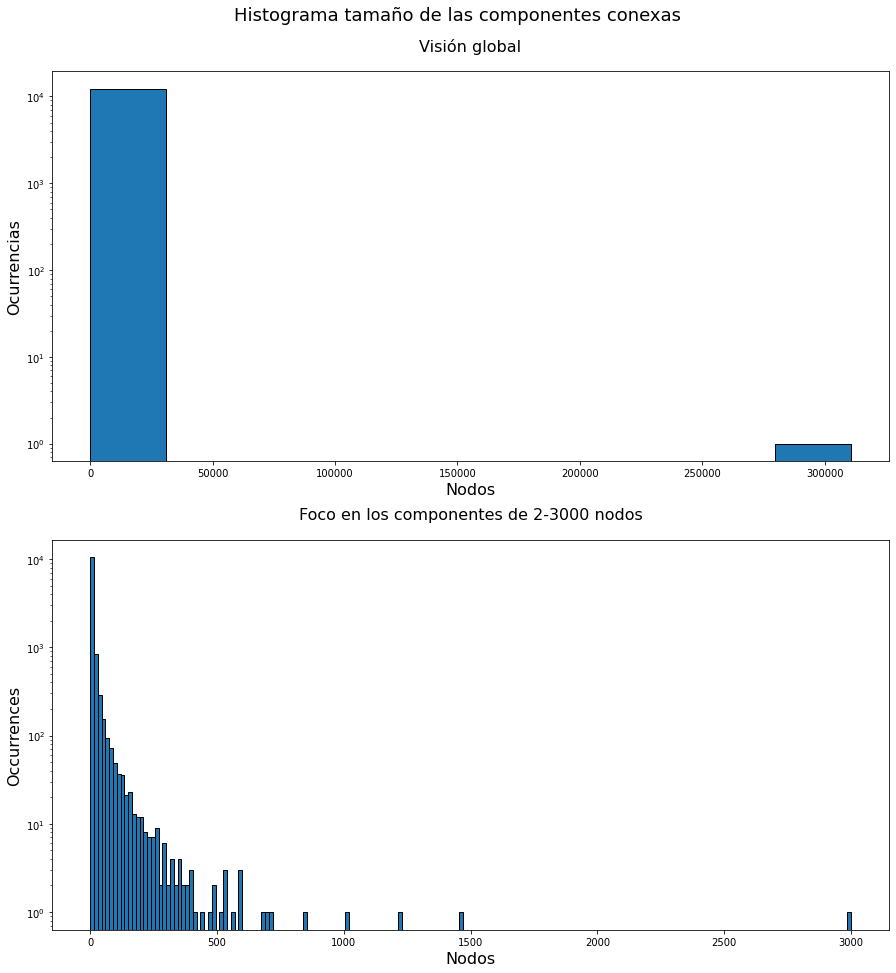

In [11]:
## Histogram of component size
histogram_components = np.array(nodes_per_component)
fig, axs = plt.subplots(2,1,figsize=(15,15))
#fig.tight_layout()
fig.suptitle('Histograma tamaño de las componentes conexas',fontsize=18)
fig.subplots_adjust(top=0.92)
axs[0].set_title('Visión global',fontsize=16,pad=20)
axs[0].hist(histogram_components,ec="k")
axs[0].set_yscale('log')
axs[0].set_ylabel('Ocurrencias',fontsize=16)
axs[1].set_title('Foco en los componentes de 2-3000 nodos',fontsize=16,pad=20)
axs[1].hist(histogram_components,ec="k",range=[0,3000],bins=200)
axs[1].set_yscale('log')
axs[1].set_ylabel('Occurrences',fontsize=16)
axs[1].set_xlabel("Nodos",fontsize=16)
axs[0].set_xlabel("Nodos",fontsize=16)
plt.show()

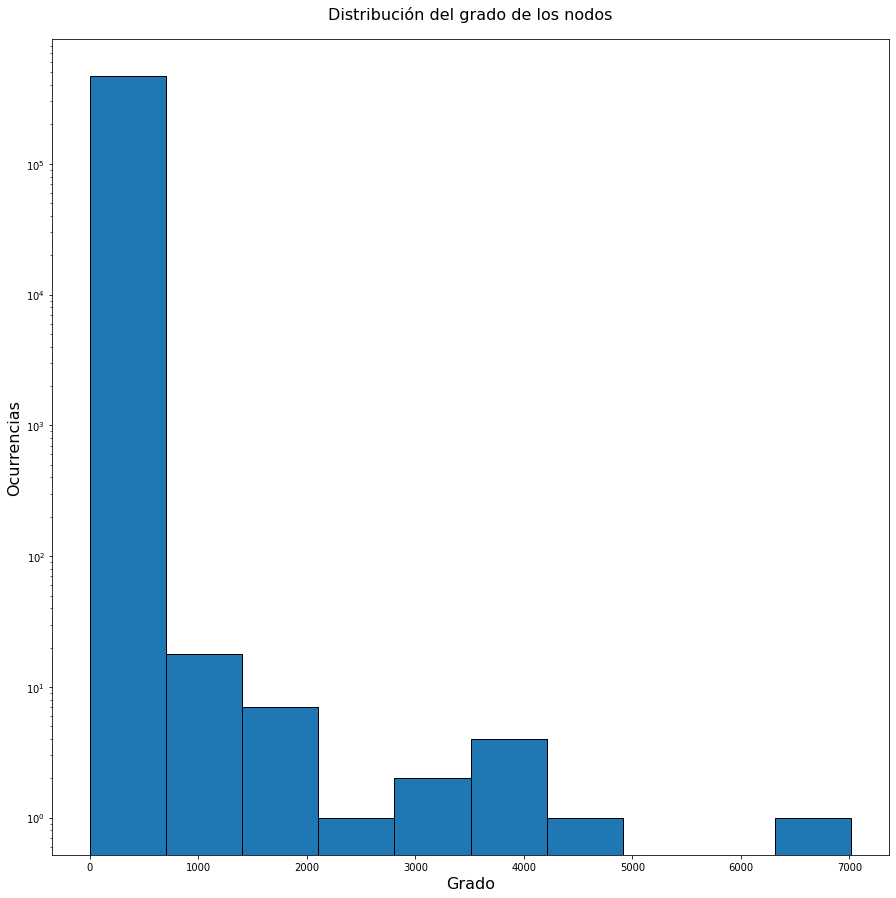

In [12]:
## Node degree distribution graph
histogram_degrees = list(dict(nx.degree(G)).values())
fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.hist(histogram_degrees,ec="k")
axs.set_title('Distribución del grado de los nodos',fontsize=16,pad=20)
axs.set_xlabel('Grado',fontsize=16)
axs.set_ylabel('Ocurrencias',fontsize=16)
axs.set_yscale('log')
plt.show()

In [13]:
## Get components with more than 500 nodes
component_index = []
for i,k in enumerate(nodes_per_component):
    if k > 500:
        component_index.append(i)
len(component_index)

18

In [14]:
### Distribution of nodes per component
final_data = []
for i in component_index:
    labels = {}
    for n, d in S[i].nodes(data=True):
        l = d['kind']
        labels[l] = labels.get(l, [])
        labels[l].append(n)
    final_data.append(labels)

for i,labels in enumerate(final_data):
    print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(S[component_index[i]].nodes)*100,2))
    print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(S[component_index[i]])*100,2))
    print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(S[component_index[i]])*100,2))
    print('---------------------------------------------------------------------')

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57
---------------------------------------------------------------------
Number of Entity nodes: 217  ====> Proportion(%): 38.14
Number of Officer nodes: 351  ====> Proportion(%): 61.69
Number of Intermediary nodes: 1  ====> Proportion(%): 0.18
---------------------------------------------------------------------
Number of Entity nodes: 2986  ====> Proportion(%): 99.7
Number of Officer nodes: 8  ====> Proportion(%): 0.27
Number of Intermediary nodes: 1  ====> Proportion(%): 0.03
---------------------------------------------------------------------
Number of Entity nodes: 284  ====> Proportion(%): 39.94
Number of Officer nodes: 426  ====> Proportion(%): 59.92
Number of Intermediary nodes: 1  ====> Proportion(%): 0.14
---------------------------------------------------------------------
Number of Entity nodes: 231

In [15]:
## Graph degree occurrence
dfr = pd.DataFrame.from_dict(Counter(list(dict(nx.degree(G)).values())), orient='index')
dfr.sort_index(inplace=True)
dfr.rename(columns={0: 'Occurrences degree'},inplace=True)
print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |               323508 |
|    2 |                60988 |
|    3 |                38642 |
|    4 |                14328 |
|    5 |                13717 |
|    6 |                 4347 |
|    7 |                 2721 |
|    8 |                 1424 |
|    9 |                  988 |
|   10 |                  618 |
|   11 |                  626 |
|   12 |                  416 |
|   13 |                  309 |
|   14 |                  213 |
|   15 |                  203 |
|   16 |                  184 |
|   17 |                  139 |
|   18 |                  114 |
|   19 |                  111 |
|   20 |                  102 |
|   21 |                  120 |
|   22 |                   94 |
|   23 |                   81 |
|   24 |                   74 |
|   25 |                   68 |
|   26 |                   75 |
|   27 |                   57 |
|   28 |                   54 |
|   29 |

In [16]:
## Components degree occurrence
for i in component_index:
    dfr = pd.DataFrame.from_dict(Counter(list(dict(nx.degree(S[i])).values())), orient='index')
    dfr.sort_index(inplace=True)
    dfr.rename(columns={0: 'Occurrences degree'},inplace=True)
    print(tabulate(dfr, headers='keys', tablefmt='psql'))

+------+----------------------+
|      |   Occurrences degree |
|------+----------------------|
|    1 |               204603 |
|    2 |                47080 |
|    3 |                30329 |
|    4 |                10935 |
|    5 |                 8034 |
|    6 |                 2968 |
|    7 |                 1888 |
|    8 |                  972 |
|    9 |                  636 |
|   10 |                  401 |
|   11 |                  361 |
|   12 |                  269 |
|   13 |                  192 |
|   14 |                  142 |
|   15 |                  119 |
|   16 |                  116 |
|   17 |                   95 |
|   18 |                   70 |
|   19 |                   76 |
|   20 |                   52 |
|   21 |                   60 |
|   22 |                   65 |
|   23 |                   51 |
|   24 |                   47 |
|   25 |                   39 |
|   26 |                   39 |
|   27 |                   30 |
|   28 |                   29 |
|   29 |

<Figure size 432x288 with 0 Axes>

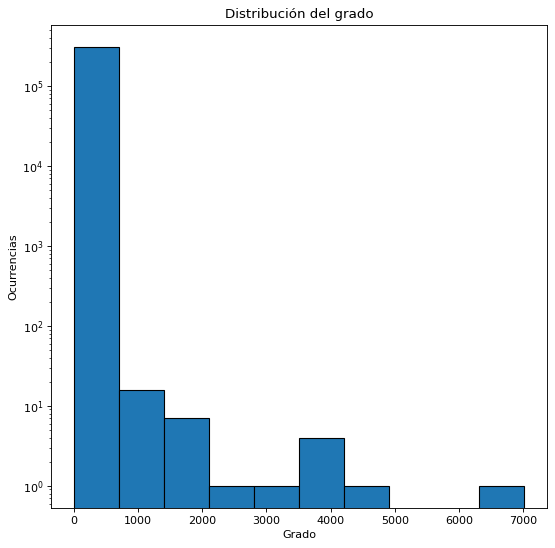

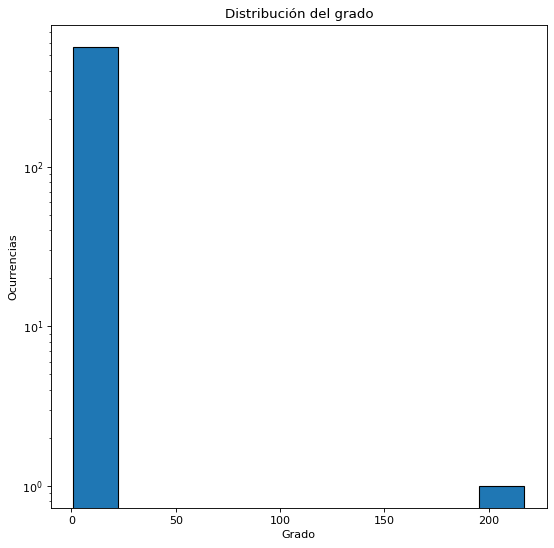

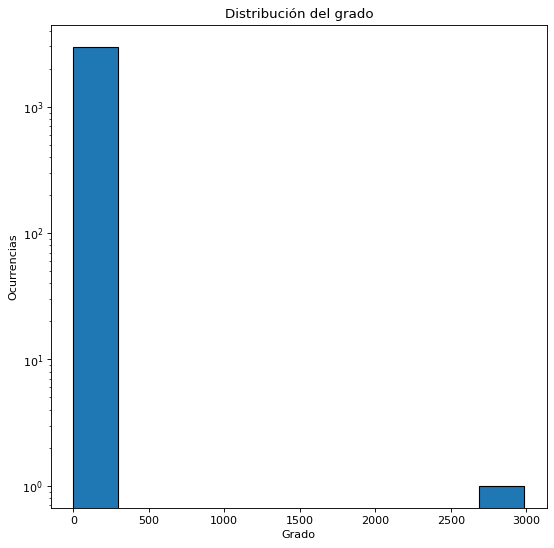

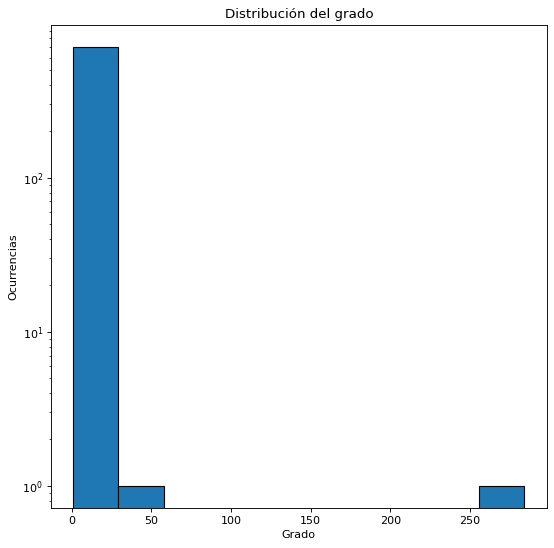

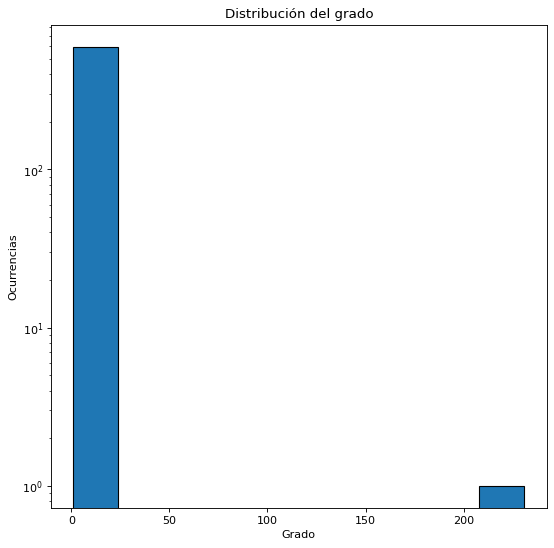

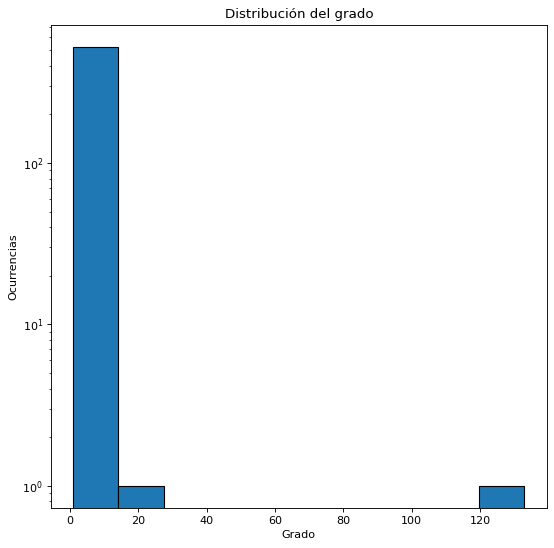

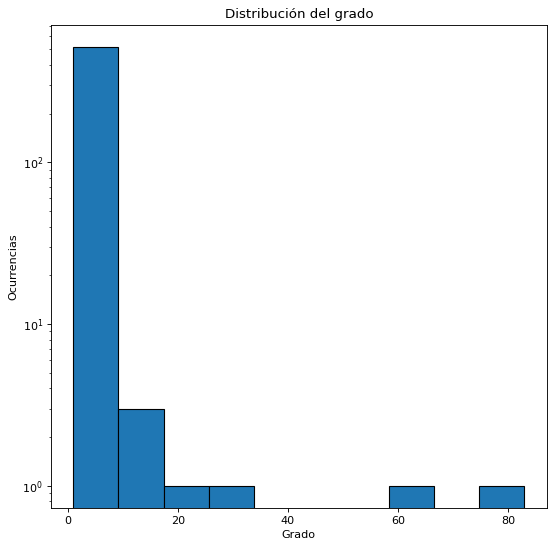

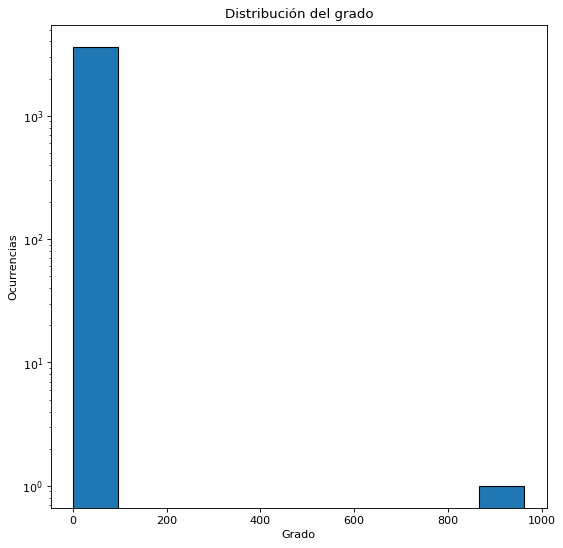

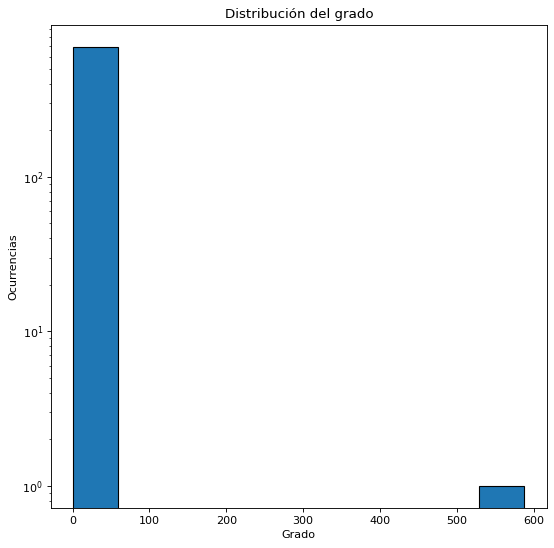

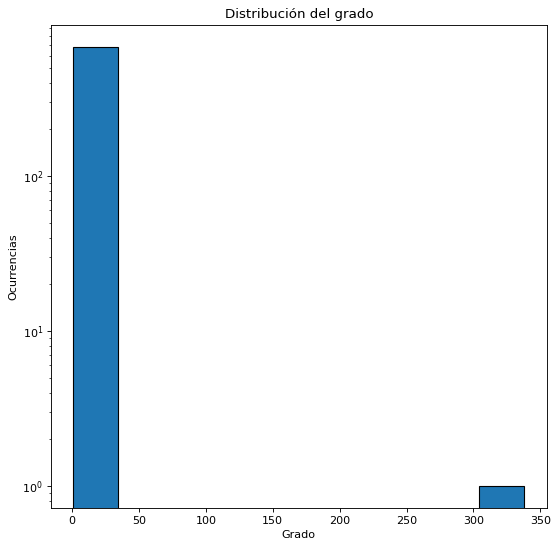

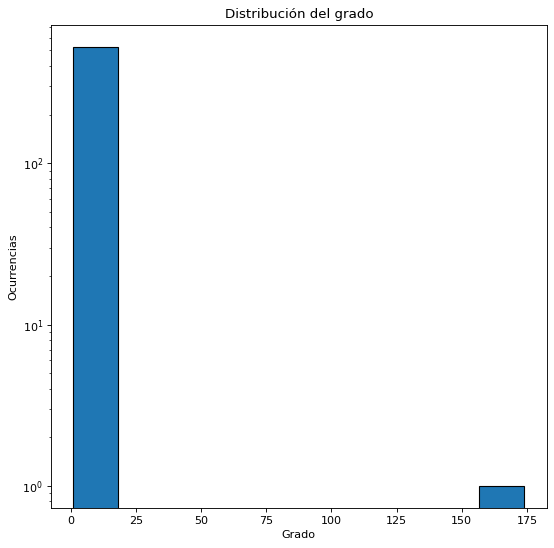

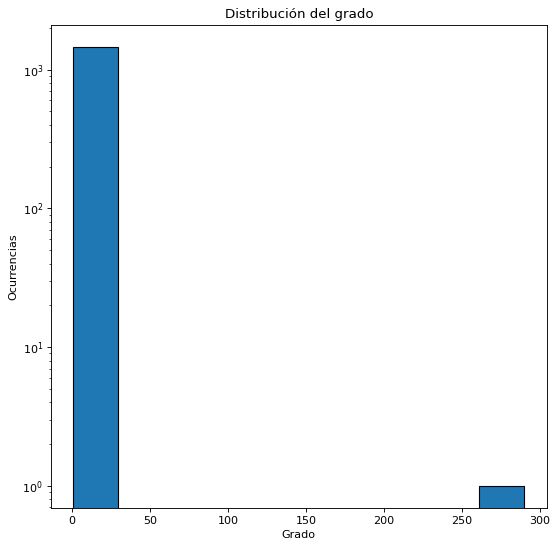

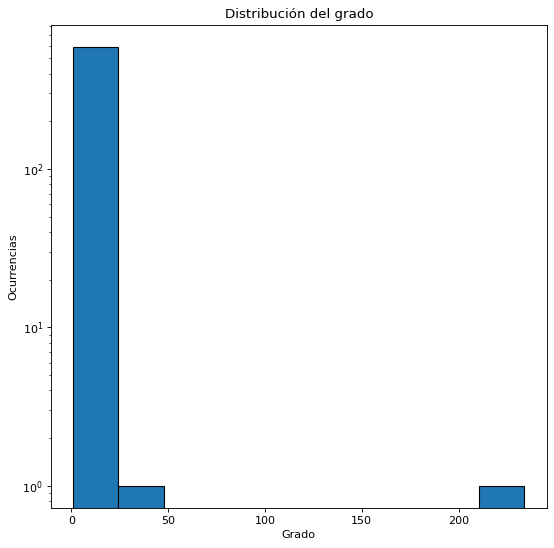

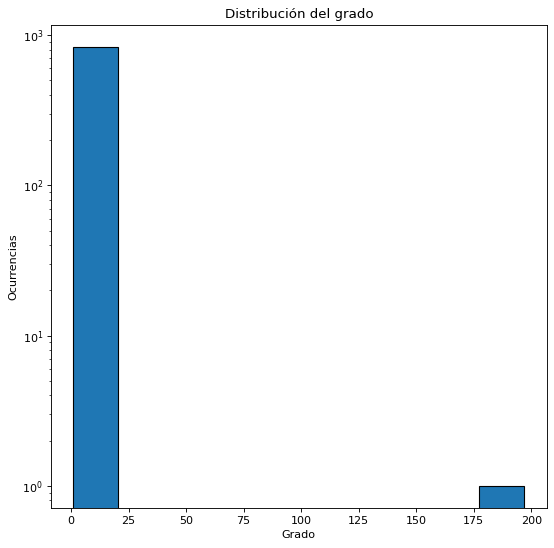

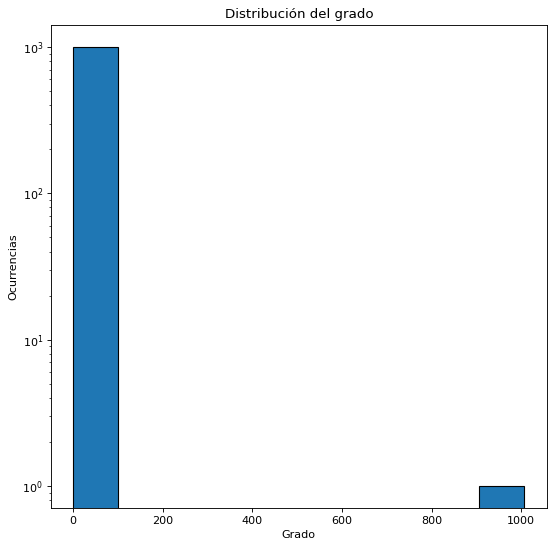

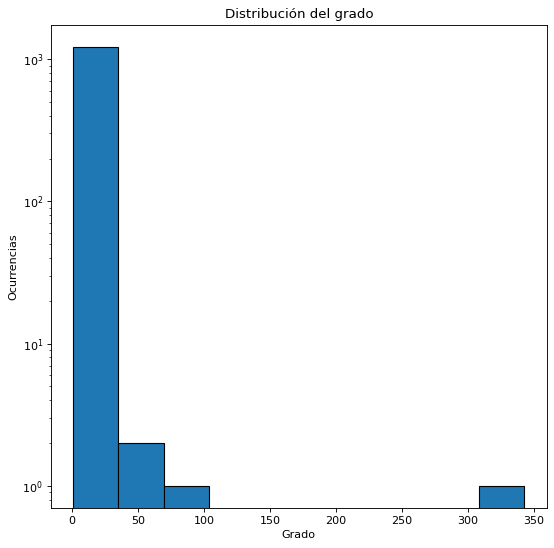

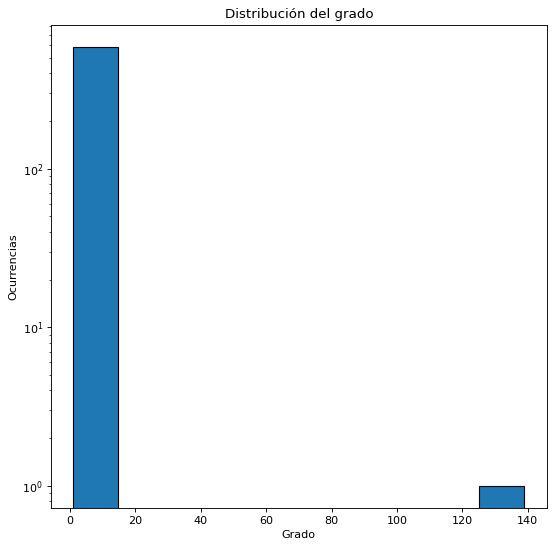

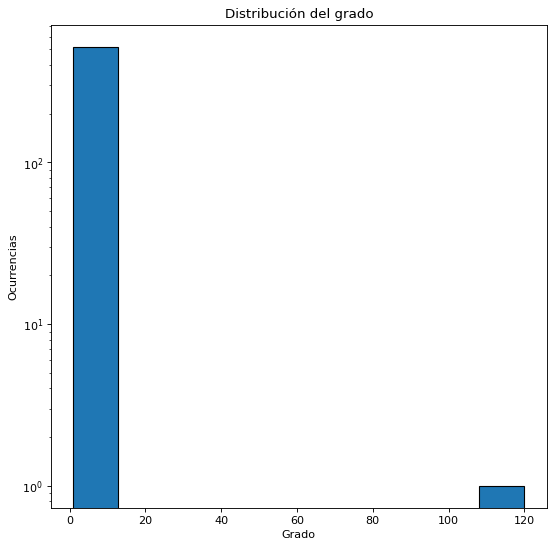

In [17]:
## Components degree histogram in different plots
for i,k in enumerate(component_index):
    plot = plt.figure(i)
    plt.figure(figsize=(8, 8), dpi=80)
    histogram_degrees = list(dict(nx.degree(S[k])).values())
    plt.yscale('log')
    plt.title("Distribución del grado")
    plt.xlabel("Grado")
    plt.ylabel("Ocurrencias")
    plt.hist(histogram_degrees,ec="k")
plt.show()

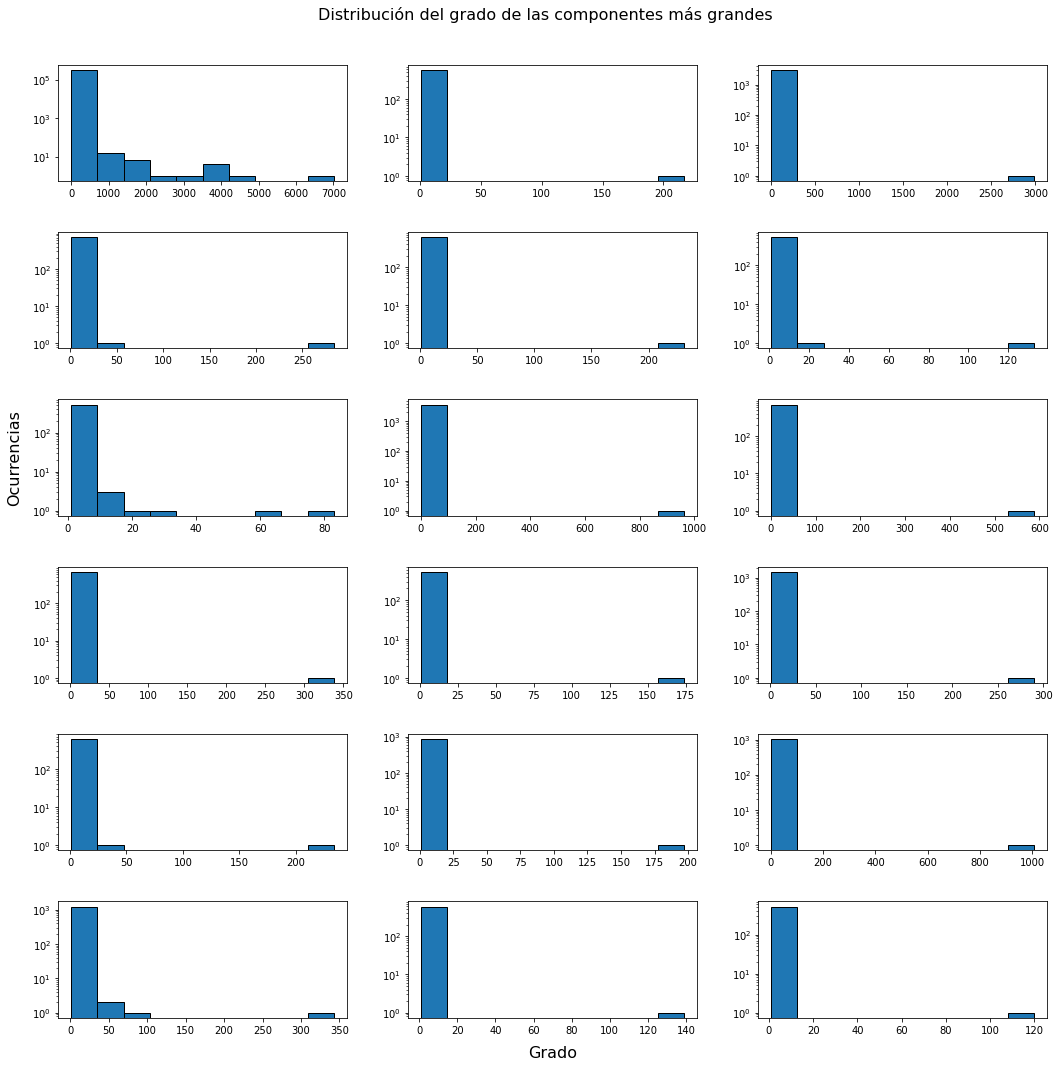

In [18]:
## Components degree histogram same plot (subplots)
fig, axs = plt.subplots(6,3,figsize=(15,15))
fig.suptitle('Distribución del grado de las componentes más grandes',fontsize=16)
fig.tight_layout(pad=3.0)
row = 0
column = 0
for i,k in enumerate(component_index):
    histogram_degrees = list(dict(nx.degree(S[k])).values())
    axs[row,column].hist(histogram_degrees,ec="k")
    #axs[row,column].set(xlabel='Grado')
    axs[row,column].set_yscale('log')
    if column > 1:
        column = 0
        row = row+1
    else:
        column=column+1
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[5,1].set_xlabel('Grado',fontsize=16,labelpad=10)
axs[2,0].set_ylabel('Ocurrencias',fontsize=16,labelpad=10)
#plt.ylabel("Ocurrencias",fontsize=16)
plt.show()

In [19]:
## Focus on greatest component
G = S[0]

In [20]:
## Goodness fit to power law distribution
def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    #print(popt_log, pcov_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)

histogram_degrees = list(dict(G.degree()).values())
diccionario = dict(Counter(histogram_degrees))
xs = []
ys = []
for i,k in diccionario.items():
    xs.append(i)
    ys.append(k)

Z = [ys for _,x in sorted(zip(xs,ys))]
xs = sorted(xs)
popt_log, pcov_log, ydatafit_log= curve_fit_log(xs,ys)

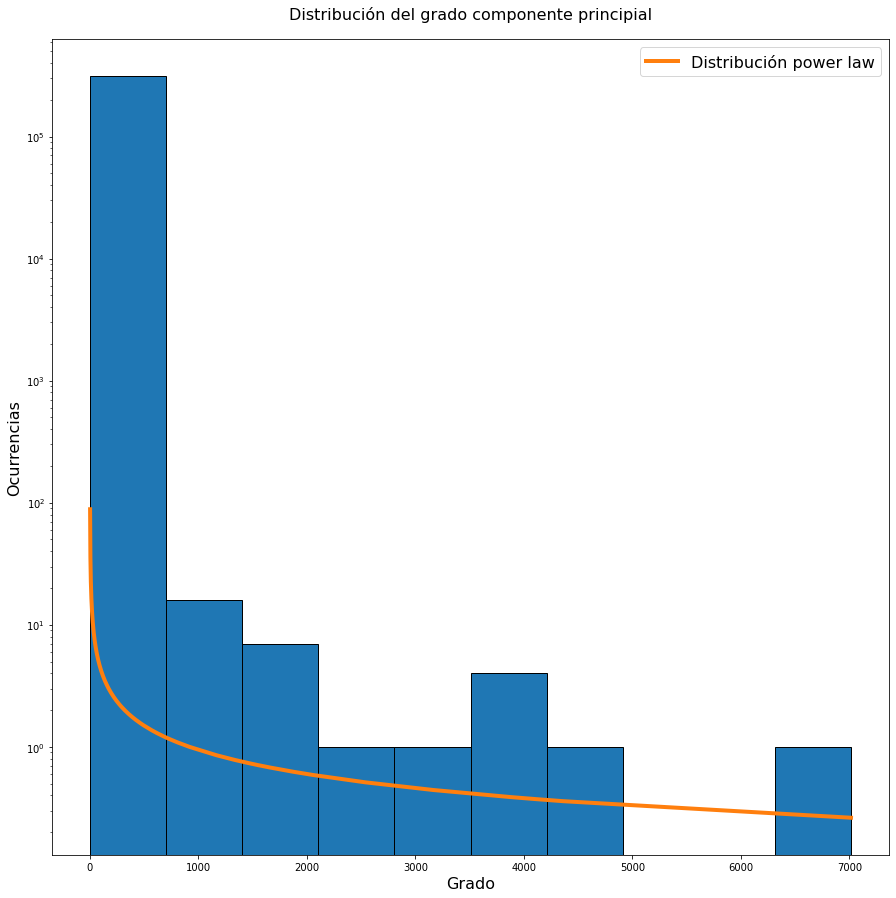

In [21]:
## Node degree distribution graph
histogram_degrees = list(dict(nx.degree(G)).values())
fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.hist(histogram_degrees,ec="k")
axs.set_title('Distribución del grado componente principial',fontsize=16,pad=20)
axs.set_xlabel('Grado',fontsize=16)
axs.set_ylabel('Ocurrencias',fontsize=16)
axs.set_yscale('log')
plt.plot(xs, ydatafit_log,label="Distribución power law",linewidth=4)
plt.legend(fontsize=16)
plt.show()

In [22]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [23]:
## Entity degree distribution
dfr_entity = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Entity'])).values())), orient='index')
dfr_entity.sort_index(inplace=True)
dfr_entity.rename(columns={0: 'Entity Occurrences degree'},inplace=True)
print(tabulate(dfr_entity, headers='keys', tablefmt='psql'))

+-----+-----------------------------+
|     |   Entity Occurrences degree |
|-----+-----------------------------|
|   1 |                       53449 |
|   2 |                       39985 |
|   3 |                       28279 |
|   4 |                        9980 |
|   5 |                        7479 |
|   6 |                        2594 |
|   7 |                        1617 |
|   8 |                         795 |
|   9 |                         492 |
|  10 |                         261 |
|  11 |                         268 |
|  12 |                         174 |
|  13 |                         107 |
|  14 |                          67 |
|  15 |                          54 |
|  16 |                          42 |
|  17 |                          38 |
|  18 |                          19 |
|  19 |                          17 |
|  20 |                          15 |
|  21 |                          34 |
|  22 |                          26 |
|  23 |                          12 |
|  24 |     

In [24]:
print(np.mean(list(dict(G.degree(labels['Entity'])).values())))
print(np.mean(list(dict(G.degree(labels['Officer'])).values())))
print(np.mean(list(dict(G.degree(labels['Intermediary'])).values())))

2.461717064484093
1.310060341176254
82.86322360953461


In [25]:
## Intermediary degree distribution
dfr_intermediary = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Intermediary'])).values())), orient='index')
dfr_intermediary.sort_index(inplace=True)
dfr_intermediary.rename(columns={0: 'Intermediary Occurrences degree'},inplace=True)
print(tabulate(dfr_intermediary, headers='keys', tablefmt='psql'))

+------+-----------------------------------+
|      |   Intermediary Occurrences degree |
|------+-----------------------------------|
|    1 |                               345 |
|    2 |                               146 |
|    3 |                                87 |
|    4 |                                67 |
|    5 |                                52 |
|    6 |                                45 |
|    7 |                                50 |
|    8 |                                27 |
|    9 |                                29 |
|   10 |                                33 |
|   11 |                                18 |
|   12 |                                25 |
|   13 |                                28 |
|   14 |                                24 |
|   15 |                                23 |
|   16 |                                23 |
|   17 |                                17 |
|   18 |                                 9 |
|   19 |                                12 |
|   20 |  

In [26]:
## Officer degree distribution
dfr_officer = pd.DataFrame.from_dict(Counter(list(dict(G.degree(labels['Officer'])).values())), orient='index')
dfr_officer.sort_index(inplace=True)
dfr_officer.rename(columns={0: 'Officer Occurrences degree'},inplace=True)
print(tabulate(dfr_officer, headers='keys', tablefmt='psql'))

+------+------------------------------+
|      |   Officer Occurrences degree |
|------+------------------------------|
|    1 |                       150809 |
|    2 |                         6949 |
|    3 |                         1963 |
|    4 |                          888 |
|    5 |                          503 |
|    6 |                          329 |
|    7 |                          221 |
|    8 |                          150 |
|    9 |                          115 |
|   10 |                          107 |
|   11 |                           75 |
|   12 |                           70 |
|   13 |                           57 |
|   14 |                           51 |
|   15 |                           42 |
|   16 |                           51 |
|   17 |                           40 |
|   18 |                           42 |
|   19 |                           47 |
|   20 |                           27 |
|   21 |                           14 |
|   22 |                           23 |


In [27]:
## Node with max degree of each type
officer_dict = dict(G.degree(labels['Officer']))
intermediary_dict = dict(G.degree(labels['Intermediary']))
entity_dict = dict(G.degree(labels['Entity']))
officer_index = max(officer_dict, key=officer_dict.get)
intermediary_index = max(intermediary_dict, key=intermediary_dict.get)
entity_index = max(entity_dict, key=entity_dict.get)

print(G.nodes[officer_index])
print(G.nodes[intermediary_index])
print(G.nodes[entity_index])

{'kind': 'Officer', 'properties': {'sourceID': 'Panama Papers', 'note': '', 'valid_until': 'The Panama Papers data is current through 2015', 'name': 'MOSSFON SUBSCRIBERS LTD.', 'country_codes': 'WSM', 'countries': 'Samoa', 'node_id': '12160432'}}
{'kind': 'Intermediary', 'properties': {'sourceID': 'Panama Papers', 'note': '', 'valid_until': 'The Panama Papers  data is current through 2015', 'name': 'ORION HOUSE SERVICES (HK) LIMITED', 'country_codes': 'HKG', 'countries': 'Hong Kong', 'node_id': '11001746', 'status': 'ACTIVE'}}
{'kind': 'Entity', 'properties': {'sourceID': 'Panama Papers', 'company_type': '', 'note': '', 'closed_date': '', 'jurisdiction': 'BVI', 'struck_off_date': '30-APR-2006', 'service_provider': 'Mossack Fonseca', 'countries': 'Switzerland', 'jurisdiction_description': 'British Virgin Islands', 'valid_until': 'The Panama Papers data is current through 2015', 'ibcRUC': '562684', 'name': 'VELA GAS INVESTMENTS LTD.', 'country_codes': 'CHE', 'inactivation_date': '03-MAY-

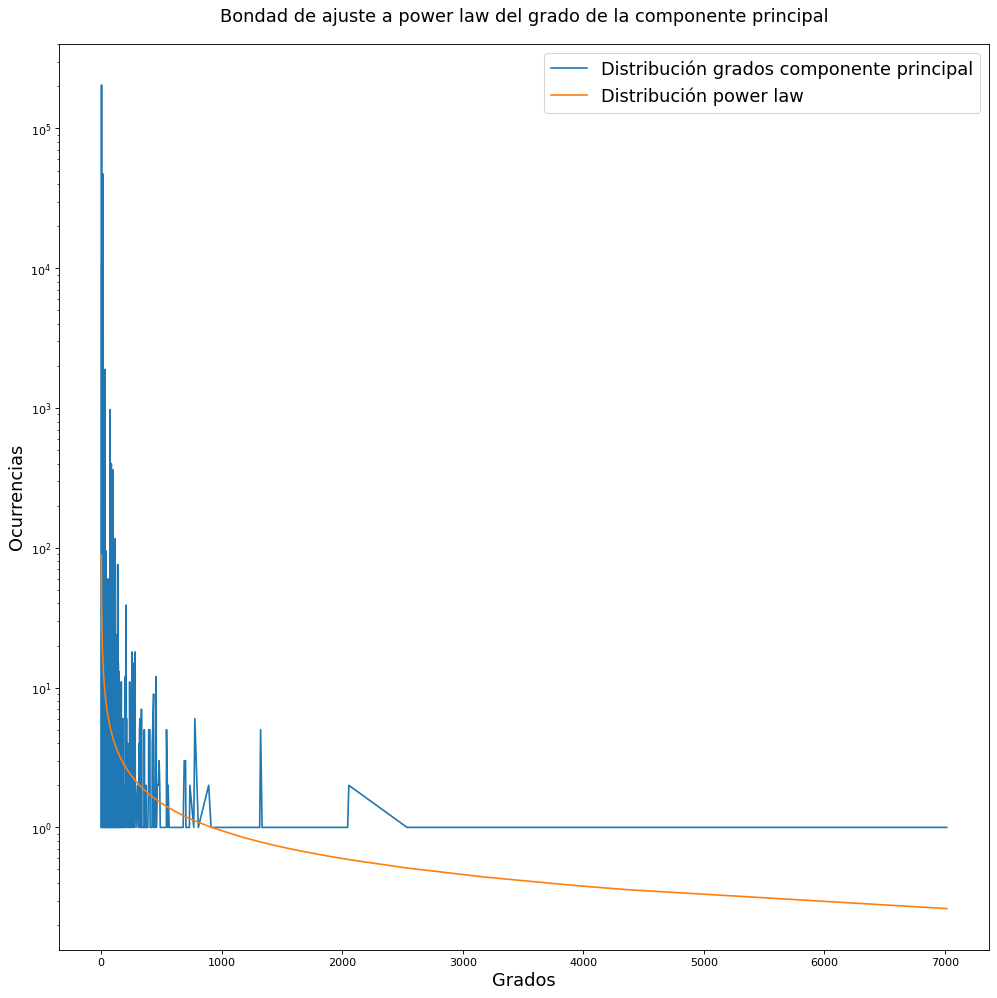

In [28]:
## Goodness fit to power law distribution
def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    #print(popt_log, pcov_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)

histogram_degrees = list(dict(G.degree()).values())
diccionario = dict(Counter(histogram_degrees))
xs = []
ys = []
for i,k in diccionario.items():
    xs.append(i)
    ys.append(k)

Z = [ys for _,x in sorted(zip(xs,ys))]
xs = sorted(xs)
popt_log, pcov_log, ydatafit_log= curve_fit_log(xs,ys)

plt.figure(figsize=(15, 15), dpi=80)
plt.plot(xs, ys,label="Distribución grados componente principal")
plt.title('Bondad de ajuste a power law del grado de la componente principal',pad=20,fontsize=16)
plt.xlabel('Grados',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.yscale('log')
plt.plot(xs, ydatafit_log,label="Distribución power law")
plt.legend(fontsize=16)
plt.show()

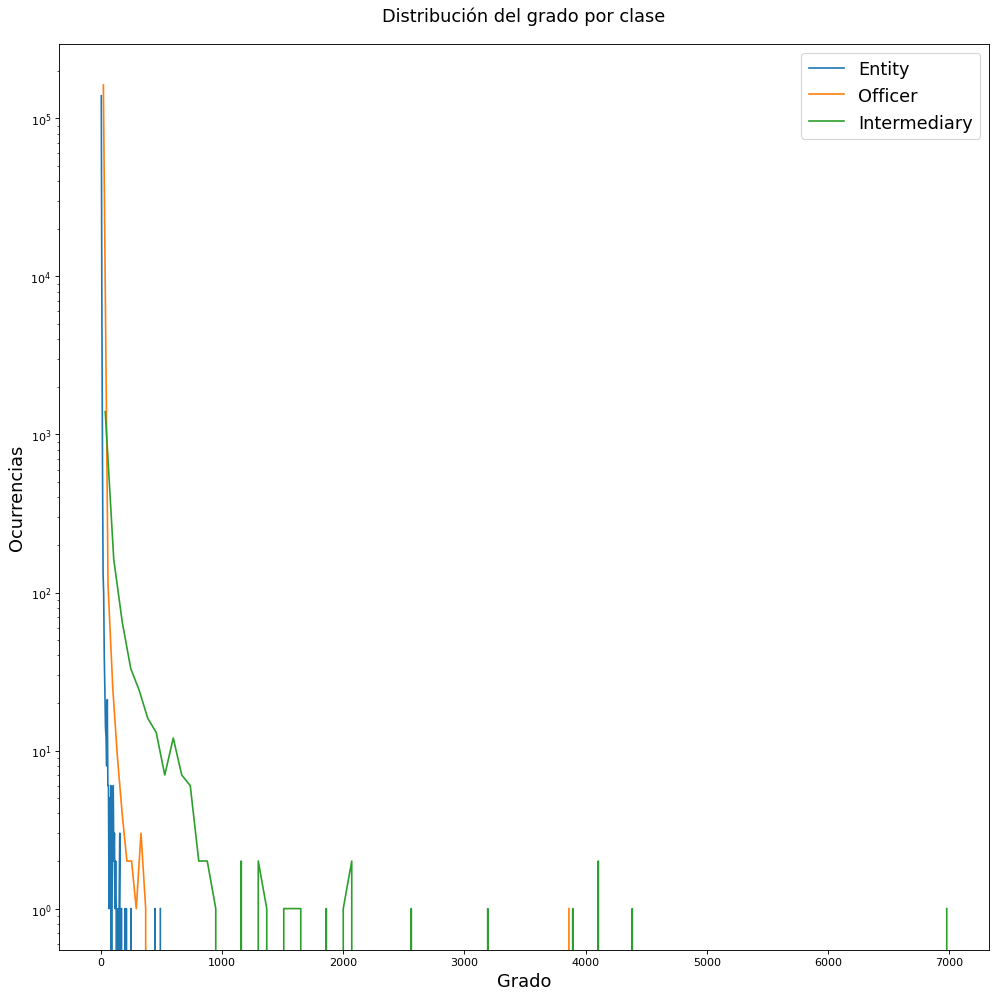

In [29]:
## Node degree per type
histogram_degrees_entity = list(dict(G.degree(labels['Entity'])).values())
histogram_degrees_officer = list(dict(G.degree(labels['Officer'])).values())
histogram_degrees_intermediaries = list(dict(G.degree(labels['Intermediary'])).values())

plt.figure(figsize=(15, 15), dpi=80)
y,binEdges=np.histogram(histogram_degrees_entity,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Entity")

y,binEdges=np.histogram(histogram_degrees_officer,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Officer")

y,binEdges=np.histogram(histogram_degrees_intermediaries,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-',label="Intermediary")

plt.title('Distribución del grado por clase',fontsize=16,pad=20)
plt.xlabel('Grado',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)
p.show()

In [30]:
## Node associativity compute

scatter_associativity = []
scatter_associativity_entity = []
scatter_associativity_officer = []
scatter_associativity_intermediary = []
scatter_associativity_mean = []
scatter_associativity_entity_mean = []
scatter_associativity_officer_mean = []
scatter_associativity_intermediary_mean = []
for node_id,metadata in G.nodes(data=True):
    node_degree = G.degree(node_id)
    degree_mean = 0
    number_of_neighbors = len(list(G.neighbors(node_id)))
    for node_neighbor in G.neighbors(node_id):
        neighbor_degree = G.degree(node_neighbor)
        degree_mean = neighbor_degree + degree_mean
        scatter_associativity.append(list([node_degree, neighbor_degree]))
        if G.nodes[node_id]['kind'] == 'Entity':
            scatter_associativity_entity.append(list([node_degree, neighbor_degree]))
        elif G.nodes[node_id]['kind'] == 'Officer':
            scatter_associativity_officer.append(list([node_degree, neighbor_degree]))
        else:
            scatter_associativity_intermediary.append(list([node_degree, neighbor_degree]))
    scatter_associativity_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    if G.nodes[node_id]['kind'] == 'Entity':
        scatter_associativity_entity_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    elif G.nodes[node_id]['kind'] == 'Officer':
        scatter_associativity_officer_mean.append(list([node_degree, degree_mean/number_of_neighbors]))
    else:
        scatter_associativity_intermediary_mean.append(list([node_degree, degree_mean/number_of_neighbors]))

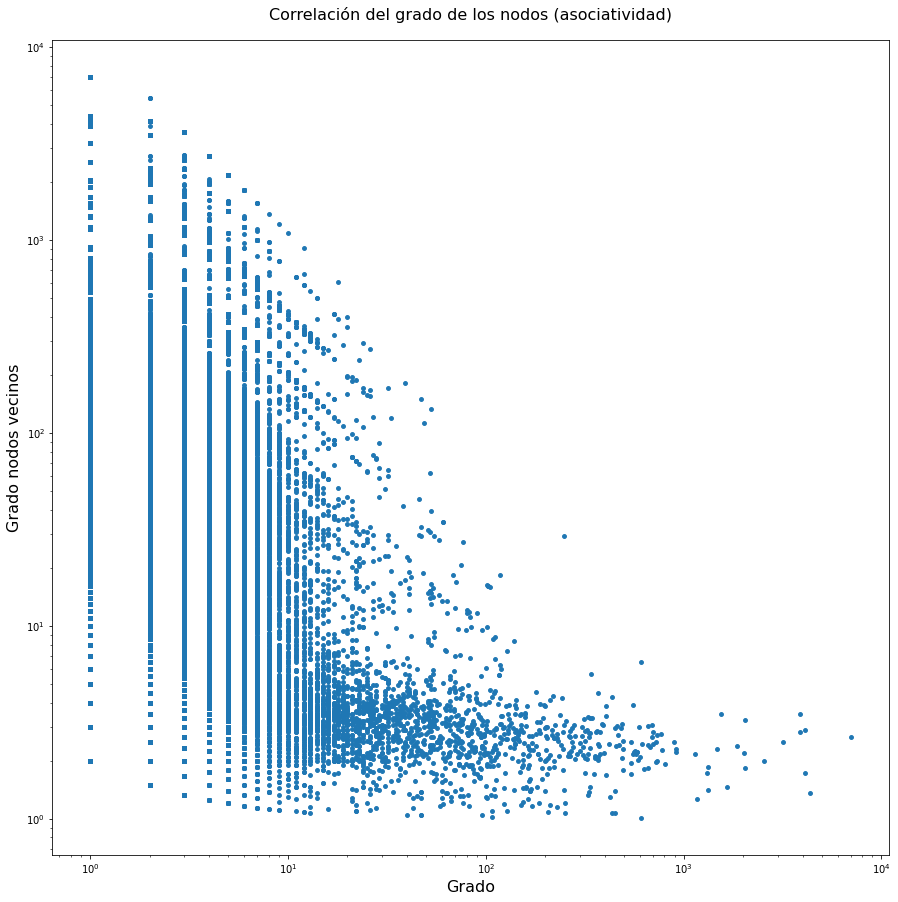

In [31]:
## Node associativity plot
fig, axs = plt.subplots(1,1,figsize=(15,15))
x,y = (np.array(scatter_associativity_mean)).T
plt.scatter(x,y,s=15)
plt.title('Correlación del grado de los nodos (asociatividad)', fontsize=16,pad=20)
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Grado nodos vecinos', fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.show()

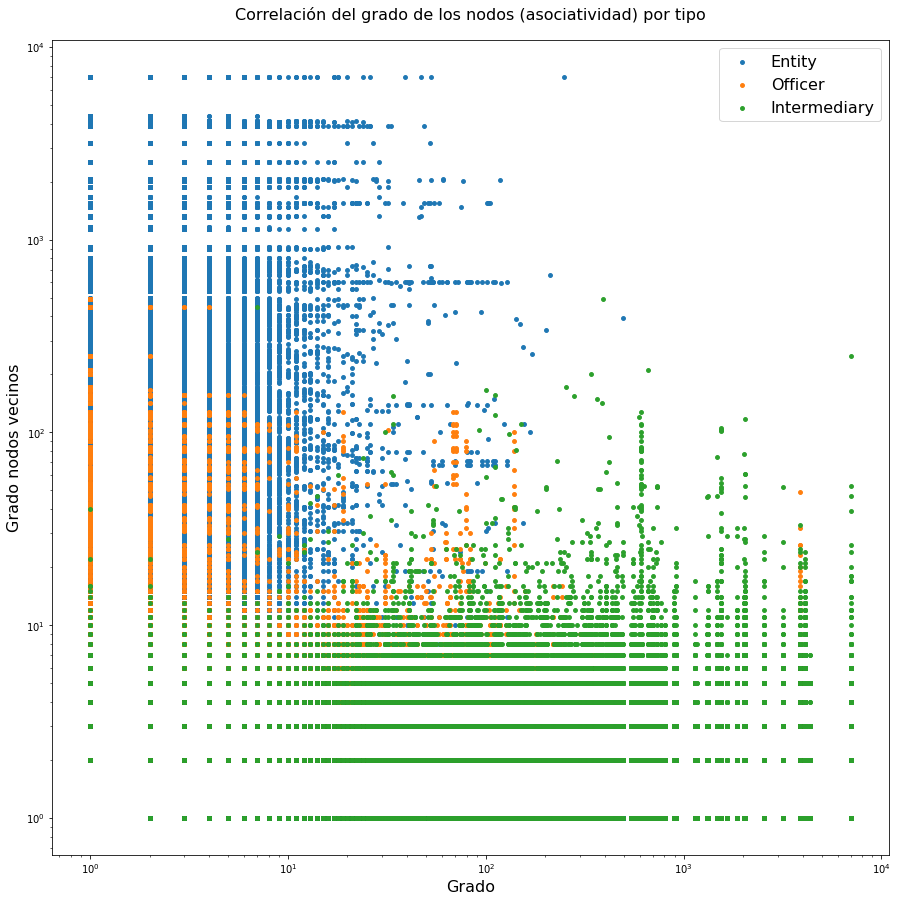

In [32]:
## Node associativity per node kind
x_entity,y_entity = (np.array(scatter_associativity_entity)).T
x_officer,y_officer = (np.array(scatter_associativity_officer)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_entity,y_entity,s=15,label="Entity")
plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.show()

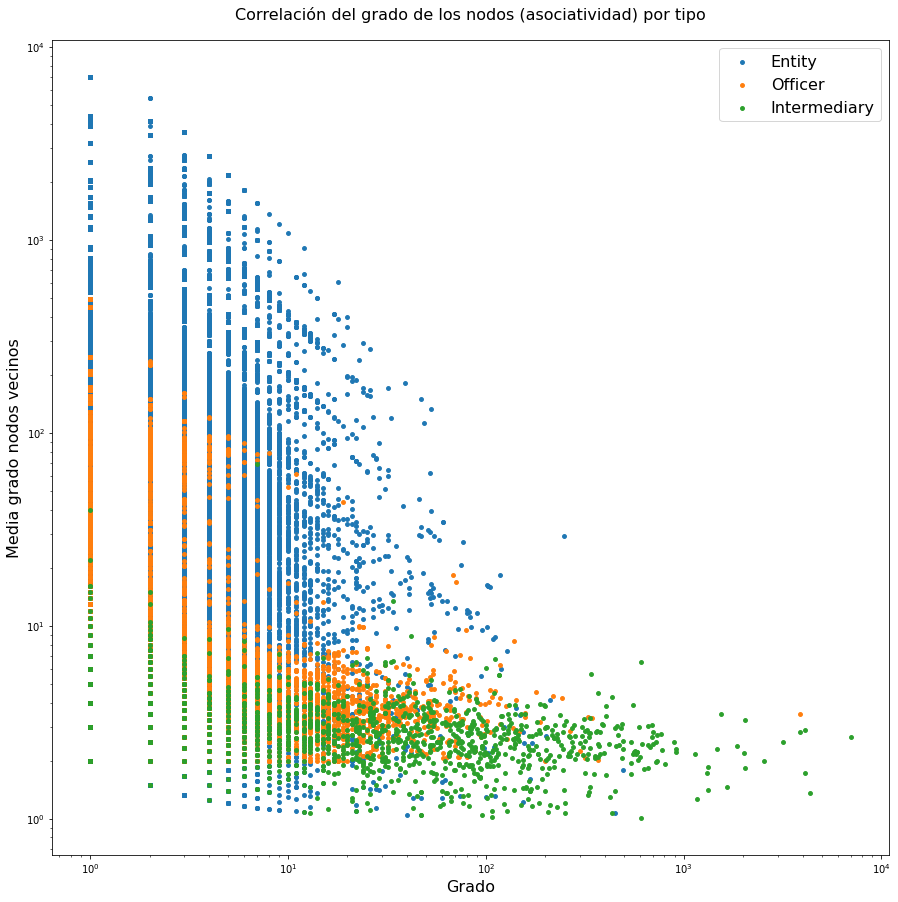

In [33]:
## Node associativity per node kind (neighbor mean)
x_entity,y_entity = (np.array(scatter_associativity_entity_mean)).T
x_officer,y_officer = (np.array(scatter_associativity_officer_mean)).T
x_intermediary,y_intermediary = (np.array(scatter_associativity_intermediary_mean)).T

fig, axs = plt.subplots(1,1,figsize=(15,15))

plt.scatter(x_entity,y_entity,s=15,label="Entity")
plt.scatter(x_officer,y_officer,s=15,label="Officer")
plt.scatter(x_intermediary,y_intermediary,s=15,label="Intermediary")
plt.xlabel('Grado', fontsize=16)
plt.ylabel('Media grado nodos vecinos', fontsize=16)
plt.title('Correlación del grado de los nodos (asociatividad) por tipo',fontsize=16,pad=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.show()

In [34]:
## Distribution of each kind of officer edges
shareholder = 0
beneficiary = 0
director    = 0
officer     = 0
for data in G.edges(labels['Officer'],data=True):
    if data[2]['type'] == 'SHAREHOLDER_OF':
        shareholder = shareholder +1
    elif data[2]['type'] == 'BENEFICIARY_OF':
        beneficiary = beneficiary +1
    elif data[2]['type'] == 'OFFICER_OF':
        officer = officer +1
    else:
        director = director +1

print('Shareholder', shareholder/(shareholder+beneficiary+director+officer))
print('Bneficiary', beneficiary/(shareholder+beneficiary+director+officer))
print('Director', director)
print('Officer', officer)

Shareholder 0.9479050501832086
Bneficiary 0.05148113092616368
Director 24
Officer 107


<BarContainer object of 4 artists>

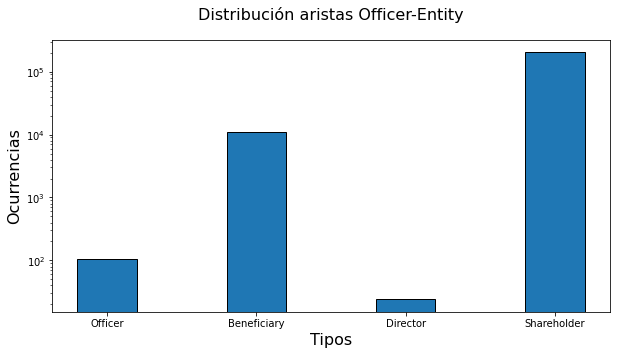

In [35]:
x = ["Officer", "Beneficiary", "Director", "Shareholder"]
y = [officer, beneficiary, director, shareholder]
  
fig = plt.figure(figsize = (10, 5))
 
plt.yscale('log')
plt.title('Distribución aristas Officer-Entity',fontsize=16,pad=20)
plt.xlabel('Tipos',fontsize=16)
plt.ylabel('Ocurrencias',fontsize=16)
plt.bar(x, y, width = 0.4,ec="k")
 

In [36]:
total_edges = sum(list(dict(G.degree(labels['Officer'])).values()))
print("Number of relationshipts known as 'shareholder_of': " , shareholder/total_edges*100)
print("Number of relationshipts known as 'beneficiary_of': " , beneficiary/total_edges*100)
print("Number of relationshipts known as 'director_of': " , director/total_edges*100)
print("Number of relationshipts known as 'officer_of': " , officer/total_edges*100)

Number of relationshipts known as 'shareholder_of':  94.79050501832086
Number of relationshipts known as 'beneficiary_of':  5.148113092616368
Number of relationshipts known as 'director_of':  0.011245536927531885
Number of relationshipts known as 'officer_of':  0.05013635213524632


In [37]:
print(nx.is_connected(G))
total_graph = G.number_of_nodes()
scatter = []

True


In [38]:
## Percolation first iteration
max_degree_id = max(dict(G.degree(labels['Intermediary'])), key=dict(G.degree(labels['Intermediary'])).get)
Percolation_graph = G.copy()
Percolation_graph.remove_node(max_degree_id)

print(nx.is_connected(Percolation_graph))

False


In [39]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print(len(Gcc))
Gcc = Percolation_graph.subgraph(Gcc[0])
print('The total number of components is: ',len(Gcc))
print('Proportion' + str(len(Gcc)/total_graph))
scatter.append([1,len(Gcc)/total_graph])

1
The total number of components is:  310673
Proportion0.9999967811918603


In [40]:
## Percolation second iteration
max_degree_id = max(dict(Gcc.degree(labels['Intermediary'])), key=dict(Gcc.degree(labels['Intermediary'])).get)
Percolation_graph = Gcc.copy()
Percolation_graph.remove_node(max_degree_id)
Gcc = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
Gcc = Percolation_graph.subgraph(Gcc[0])
print('The total number of components is: ',len(Gcc))
print('Proportion' + str(len(Gcc)/total_graph))
scatter.append([1,len(Gcc)/total_graph])

The total number of components is:  295504
Proportion0.9511706805204169


In [41]:
G.number_of_nodes()

310674

In [42]:
## Percolation for GCC
total_graph = G.number_of_nodes()
scatter_gcc = [[0,1]]
scatter_slcc = [[0,0]]
scatter_cc = [[0,1]]
current_length_gcc = total_graph
Percolation_graph = G.copy()
i=1
while current_length_gcc/total_graph > 0.05:
    max_degree_id = max(dict(Percolation_graph.degree(labels['Intermediary'])), key=dict(Percolation_graph.degree(labels['Intermediary'])).get)
    Percolation_graph.remove_node(max_degree_id)
    G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    scatter_cc.append([i,len(G_sorted)])
    Gcc = Percolation_graph.subgraph(G_sorted[0])
    Slcc = Percolation_graph.subgraph(G_sorted[1])
    current_length_gcc = len(Gcc)
    current_length_slcc = len(Slcc)
    print('The total number of components in Gcc is: ',current_length_gcc)
    print('The total number of components in Slcc is: ',current_length_slcc)
    print('Proportion gcc',current_length_gcc/total_graph)
    print('Proportion slcc',current_length_slcc/total_graph)
    scatter_gcc.append([i,current_length_gcc/total_graph])
    scatter_slcc.append([i,current_length_slcc/total_graph])
    i=i+1
    

The total number of components in Gcc is:  299011
The total number of components in Slcc is:  296
Proportion gcc 0.9624590406664221
Proportion slcc 0.0009527672093577191
The total number of components in Gcc is:  295504
The total number of components in Slcc is:  296
Proportion gcc 0.9511706805204169
Proportion slcc 0.0009527672093577191
The total number of components in Gcc is:  288021
The total number of components in Slcc is:  305
Proportion gcc 0.927084339210877
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  276893
The total number of components in Slcc is:  305
Proportion gcc 0.8912654422320503
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  268332
The total number of components in Slcc is:  305
Proportion gcc 0.8637092257478901
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  266107
The total number of components in Slcc is:  305
Proportion gcc 0.8565473776370086
Proportion slcc 0.0

The total number of components in Gcc is:  191353
The total number of components in Slcc is:  965
Proportion gcc 0.6159285939602284
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  190414
The total number of components in Slcc is:  965
Proportion gcc 0.6129061331170295
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  189819
The total number of components in Slcc is:  965
Proportion gcc 0.6109909422738948
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  189156
The total number of components in Slcc is:  965
Proportion gcc 0.6088568724772592
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  188723
The total number of components in Slcc is:  965
Proportion gcc 0.6074631285527595
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  188403
The total number of components in Slcc is:  965
Proportion gcc 0.6064331099480484
Proportion slcc 0.00310

The total number of components in Gcc is:  156175
The total number of components in Slcc is:  965
Proportion gcc 0.5026973612210871
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  155921
The total number of components in Slcc is:  965
Proportion gcc 0.5018797839535977
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  155035
The total number of components in Slcc is:  965
Proportion gcc 0.49902791994180395
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  154591
The total number of components in Slcc is:  965
Proportion gcc 0.49759876912776735
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  153302
The total number of components in Slcc is:  965
Proportion gcc 0.4934497254356657
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  151988
The total number of components in Slcc is:  965
Proportion gcc 0.48922021154007095
Proportion slcc 0.00

The total number of components in Gcc is:  131406
The total number of components in Slcc is:  791
Proportion gcc 0.42297070240831225
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  131406
The total number of components in Slcc is:  791
Proportion gcc 0.42297070240831225
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130901
The total number of components in Slcc is:  791
Proportion gcc 0.42134520429775263
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130568
The total number of components in Slcc is:  791
Proportion gcc 0.4202733411872252
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130343
The total number of components in Slcc is:  791
Proportion gcc 0.41954910935578776
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130033
The total number of components in Slcc is:  791
Proportion gcc 0.4185512788324739
Proportion slc

The total number of components in Gcc is:  117044
The total number of components in Slcc is:  493
Proportion gcc 0.37674217990562453
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116692
The total number of components in Slcc is:  493
Proportion gcc 0.3756091594404424
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116692
The total number of components in Slcc is:  493
Proportion gcc 0.3756091594404424
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116455
The total number of components in Slcc is:  493
Proportion gcc 0.3748463019113283
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116089
The total number of components in Slcc is:  493
Proportion gcc 0.37366821813219003
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  115864
The total number of components in Slcc is:  493
Proportion gcc 0.37294398630075254
Proportion slcc

The total number of components in Gcc is:  104936
The total number of components in Slcc is:  493
Proportion gcc 0.3377688509498703
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104764
The total number of components in Slcc is:  493
Proportion gcc 0.3372152159498381
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104528
The total number of components in Slcc is:  493
Proportion gcc 0.3364555772288637
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104302
The total number of components in Slcc is:  493
Proportion gcc 0.3357281265892865
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104201
The total number of components in Slcc is:  493
Proportion gcc 0.3354030269671746
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  103631
The total number of components in Slcc is:  493
Proportion gcc 0.33356830632753304
Proportion slcc 0

The total number of components in Gcc is:  96281
The total number of components in Slcc is:  493
Proportion gcc 0.3099100665005762
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  96144
The total number of components in Slcc is:  493
Proportion gcc 0.30946908978543425
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  96042
The total number of components in Slcc is:  493
Proportion gcc 0.3091407713551826
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95893
The total number of components in Slcc is:  493
Proportion gcc 0.308661168942364
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95630
The total number of components in Slcc is:  493
Proportion gcc 0.3078146224016171
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95471
The total number of components in Slcc is:  493
Proportion gcc 0.3073028319074013
Proportion slcc 0.001586

The total number of components in Gcc is:  87277
The total number of components in Slcc is:  503
Proportion gcc 0.2809279180105191
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  87188
The total number of components in Slcc is:  503
Proportion gcc 0.2806414440860838
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  87099
The total number of components in Slcc is:  503
Proportion gcc 0.28035497016164856
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86927
The total number of components in Slcc is:  503
Proportion gcc 0.27980133516161637
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86773
The total number of components in Slcc is:  503
Proportion gcc 0.27930563870809916
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86740
The total number of components in Slcc is:  503
Proportion gcc 0.27919941803948833
Proportion slcc 0.00

The total number of components in Gcc is:  81808
The total number of components in Slcc is:  635
Proportion gcc 0.26332425629437933
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81808
The total number of components in Slcc is:  635
Proportion gcc 0.26332425629437933
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81633
The total number of components in Slcc is:  635
Proportion gcc 0.26276096486992795
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81522
The total number of components in Slcc is:  635
Proportion gcc 0.2624036771664188
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81420
The total number of components in Slcc is:  635
Proportion gcc 0.26207535873616716
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81335
The total number of components in Slcc is:  635
Proportion gcc 0.2618017600442908
Proportion slcc 0.0020439

The total number of components in Gcc is:  76194
The total number of components in Slcc is:  635
Proportion gcc 0.24525386739797989
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  76095
The total number of components in Slcc is:  635
Proportion gcc 0.2449352053921474
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75934
The total number of components in Slcc is:  635
Proportion gcc 0.24441697728165215
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75827
The total number of components in Slcc is:  635
Proportion gcc 0.2440725648107019
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75804
The total number of components in Slcc is:  635
Proportion gcc 0.24399853222348827
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75785
The total number of components in Slcc is:  635
Proportion gcc 0.24393737486883357
Proportion slcc 0.0020439

The total number of components in Gcc is:  72356
The total number of components in Slcc is:  635
Proportion gcc 0.23290008175772675
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72342
The total number of components in Slcc is:  635
Proportion gcc 0.23285501844377063
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72232
The total number of components in Slcc is:  635
Proportion gcc 0.23250094954840123
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72146
The total number of components in Slcc is:  635
Proportion gcc 0.23222413204838513
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72100
The total number of components in Slcc is:  635
Proportion gcc 0.2320760668739579
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72100
The total number of components in Slcc is:  635
Proportion gcc 0.2320760668739579
Proportion slcc 0.0020439

The total number of components in Gcc is:  67846
The total number of components in Slcc is:  635
Proportion gcc 0.2183832570475804
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67813
The total number of components in Slcc is:  635
Proportion gcc 0.21827703637896959
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67738
The total number of components in Slcc is:  635
Proportion gcc 0.21803562576849045
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67689
The total number of components in Slcc is:  635
Proportion gcc 0.21787790416964406
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67689
The total number of components in Slcc is:  635
Proportion gcc 0.21787790416964406
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67599
The total number of components in Slcc is:  635
Proportion gcc 0.21758821143706908
Proportion slcc 0.002043

The total number of components in Gcc is:  64735
The total number of components in Slcc is:  635
Proportion gcc 0.2083695449249052
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64597
The total number of components in Slcc is:  635
Proportion gcc 0.20792534940162358
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64499
The total number of components in Slcc is:  635
Proportion gcc 0.2076099062039308
Proportion slcc 0.0020439431687

The total number of components in Gcc is:  62228
The total number of components in Slcc is:  635
Proportion gcc 0.2002999929186221
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62187
The total number of components in Slcc is:  635
Proportion gcc 0.20016802178489349
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62158
The total number of components in Slcc is:  635
Proportion gcc 0.20007467634884155
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62107
The total number of components in Slcc is:  635
Proportion gcc 0.19991051713371571
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62048
The total number of components in Slcc is:  635
Proportion gcc 0.19972060745347212
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62016
The total number of components in Slcc is:  635
Proportion gcc 0.199617605593001
Proportion slcc 0.00204394

The total number of components in Gcc is:  59371
The total number of components in Slcc is:  635
Proportion gcc 0.19110385806343627
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59328
The total number of components in Slcc is:  635
Proportion gcc 0.19096544931342824
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59297
The total number of components in Slcc is:  635
Proportion gcc 0.19086566626109683
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59297
The total number of components in Slcc is:  635
Proportion gcc 0.19086566626109683
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59223
The total number of components in Slcc is:  635
Proportion gcc 0.1906274744587574
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59186
The total number of components in Slcc is:  635
Proportion gcc 0.1905083785575877
Proportion slcc 0.0020439

The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57661
The total number of components in Slcc is:  635
Proportion gcc 0.1855996961445116
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57640
The total number of components in Slcc is:  635
Proportion gcc 0.18553210117357744
Proportion slcc 0.002043

The total number of components in Gcc is:  55213
The total number of components in Slcc is:  635
Proportion gcc 0.17772005381847208
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55192
The total number of components in Slcc is:  635
Proportion gcc 0.17765245884753794
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55159
The total number of components in Slcc is:  635
Proportion gcc 0.17754623817892712
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55131
The total number of components in Slcc is:  635
Proportion gcc 0.1774561115510149
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55117
The total number of components in Slcc is:  635
Proportion gcc 0.17741104823705878
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55022
The total number of components in Slcc is:  635
Proportion gcc 0.1771052614637852
Proportion slcc 0.0020439

The total number of components in Gcc is:  53687
The total number of components in Slcc is:  635
Proportion gcc 0.1728081525972563
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53660
The total number of components in Slcc is:  635
Proportion gcc 0.1727212447774838
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53625
The total number of components in Slcc is:  635
Proportion gcc 0.17260858649259353
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53596
The total number of components in Slcc is:  635
Proportion gcc 0.1725152410565416
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53557
The total number of components in Slcc is:  635
Proportion gcc 0.1723897075390924
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53521
The total number of components in Slcc is:  635
Proportion gcc 0.17227383044606243
Proportion slcc 0.002043943

The total number of components in Gcc is:  52515
The total number of components in Slcc is:  635
Proportion gcc 0.16903570945750207
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52501
The total number of components in Slcc is:  635
Proportion gcc 0.16899064614354598
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52375
The total number of components in Slcc is:  635
Proportion gcc 0.16858507631794098
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52375
The total number of components in Slcc is:  635
Proportion gcc 0.16858507631794098
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52326
The total number of components in Slcc is:  635
Proportion gcc 0.16842735471909462
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52326
The total number of components in Slcc is:  635
Proportion gcc 0.16842735471909462
Proportion slcc 0.00204

The total number of components in Gcc is:  51568
The total number of components in Slcc is:  635
Proportion gcc 0.16598749814918531
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51554
The total number of components in Slcc is:  635
Proportion gcc 0.16594243483522922
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51554
The total number of components in Slcc is:  635
Proportion gcc 0.16594243483522922
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51514
The total number of components in Slcc is:  635
Proportion gcc 0.16581368250964032
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51514
The total number of components in Slcc is:  635
Proportion gcc 0.16581368250964032
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51504
The total number of components in Slcc is:  635
Proportion gcc 0.1657814944282431
Proportion slcc 0.002043

The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50489
The total number of components in Slcc is:  635
Proportion gcc 0.16251440416642526
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50232
The total number of components in Slcc is:  635
Proportion gcc 0.1616871704745167
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50211
The total number of components in Slcc is:  635
Proportion gcc 0.16161957550358252
Proportion slcc 0.002043

The total number of components in Gcc is:  49441
The total number of components in Slcc is:  624
Proportion gcc 0.15914109323599657
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49425
The total number of components in Slcc is:  624
Proportion gcc 0.15908959230576103
Proportion slcc 0.00200

The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49177
The total number of components in Slcc is:  590
Proportion gcc 0.15829132788710995
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49155
The total number of components in Slcc is:  590
Proportion gcc 0.1582205141080361
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49155
The total number of components in Slcc is:  590
Proportion gcc 0.1582205141080361
Proportion slcc 0.0018990968

The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48903
The total number of components in Slcc is:  590
Proportion gcc 0.15740937445682612
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48903
The total number of components in Slcc is:  590
Proportion gcc 0.15740937445682612
Proportion slcc 0.00189

The total number of components in Gcc is:  48643
The total number of components in Slcc is:  590
Proportion gcc 0.1565724843404984
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48634
The total number of components in Slcc is:  590
Proportion gcc 0.1565435150672409
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48625
The total number of components in Slcc is:  590
Proportion gcc 0.1565145457939834
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48620
The total number of components in Slcc is:  590
Proportion gcc 0.1564984517532848
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48620
The total number of components in Slcc is:  590
Proportion gcc 0.1564984517532848
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48617
The total number of components in Slcc is:  590
Proportion gcc 0.15648879532886562
Proportion slcc 0.0018990968

The total number of components in Gcc is:  48345
The total number of components in Slcc is:  590
Proportion gcc 0.15561327951486123
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48337
The total number of components in Slcc is:  590
Proportion gcc 0.15558752904974346
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48337
The total number of components in Slcc is:  590
Proportion gcc 0.15558752904974346
Proportion slcc 0.00189909

The total number of components in Gcc is:  47948
The total number of components in Slcc is:  585
Proportion gcc 0.1543354126833916
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47948
The total number of components in Slcc is:  585
Proportion gcc 0.1543354126833916
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47945
The total number of components in Slcc is:  585
Proportion gcc 0.15432575625897244
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47944
The total number of components in Slcc is:  585
Proportion gcc 0.15432253745083271
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47943
The total number of components in Slcc is:  585
Proportion gcc 0.154319318642693
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47943
The total number of components in Slcc is:  585
Proportion gcc 0.154319318642693
Proportion slcc 0.001883

The total number of components in Gcc is:  47789
The total number of components in Slcc is:  585
Proportion gcc 0.15382362218917578
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47788
The total number of components in Slcc is:  585
Proportion gcc 0.15382040338103606
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47788
The total number of components in Slcc is:  585
Proportion gcc 0.15382040338103606
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47784
The total number of components in Slcc is:  585
Proportion gcc 0.15380752814847717
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47784
The total number of components in Slcc is:  585
Proportion gcc 0.15380752814847717
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47782
The total number of components in Slcc is:  585
Proportion gcc 0.15380109053219773
Proportion slcc 0.

The total number of components in Gcc is:  47707
The total number of components in Slcc is:  585
Proportion gcc 0.1535596799217186
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47707
The total number of components in Slcc is:  585
Proportion gcc 0.1535596799217186
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47706
The total number of components in Slcc is:  585
Proportion gcc 0.15355646111357887
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47705
The total number of components in Slcc is:  585
Proportion gcc 0.15355324230543915
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47701
The total number of components in Slcc is:  585
Proportion gcc 0.15354036707288024
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47701
The total number of components in Slcc is:  585
Proportion gcc 0.15354036707288024
Proportion slcc 0.00

The total number of components in Gcc is:  47634
The total number of components in Slcc is:  585
Proportion gcc 0.15332470692751887
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47633
The total number of components in Slcc is:  585
Proportion gcc 0.15332148811937915
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47632
The total number of components in Slcc is:  585
Proportion gcc 0.15331826931123943
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47631
The total number of components in Slcc is:  585
Proportion gcc 0.1533150505030997
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47630
The total number of components in Slcc is:  585
Proportion gcc 0.15331183169496
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47629
The total number of components in Slcc is:  585
Proportion gcc 0.15330861288682027
Proportion slcc 0.0018

The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47614
The total number of components in Slcc is:  585
Proportion gcc 0.15326033076472445
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47614
The total number of components in Slcc is:  585
Proportion gcc 0.15326033076472445
Proportion slcc 0.

The total number of components in Gcc is:  47583
The total number of components in Slcc is:  585
Proportion gcc 0.15316054771239304
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47583
The total number of components in Slcc is:  585
Proportion gcc 0.15316054771239304
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47582
The total number of components in Slcc is:  585
Proportion gcc 0.15315732890425332
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47582
The total number of components in Slcc is:  585
Proportion gcc 0.15315732890425332
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47581
The total number of components in Slcc is:  585
Proportion gcc 0.1531541100961136
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47581
The total number of components in Slcc is:  585
Proportion gcc 0.1531541100961136
Proportion slcc 0.00

The total number of components in Gcc is:  47555
The total number of components in Slcc is:  585
Proportion gcc 0.15307042108448085
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47555
The total number of components in Slcc is:  585
Proportion gcc 0.15307042108448085
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47554
The total number of components in Slcc is:  585
Proportion gcc 0.15306720227634113
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47553
The total number of components in Slcc is:  585
Proportion gcc 0.15306398346820138
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47552
The total number of components in Slcc is:  585
Proportion gcc 0.15306076466006166
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47551
The total number of components in Slcc is:  585
Proportion gcc 0.15305754585192194
Proportion slcc 0.

The total number of components in Gcc is:  47523
The total number of components in Slcc is:  585
Proportion gcc 0.15296741922400972
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47523
The total number of components in Slcc is:  585
Proportion gcc 0.15296741922400972
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47522
The total number of components in Slcc is:  585
Proportion gcc 0.15296420041587
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47521
The total number of components in Slcc is:  585
Proportion gcc 0.15296098160773028
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47520
The total number of components in Slcc is:  585
Proportion gcc 0.15295776279959056
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47520
The total number of components in Slcc is:  585
Proportion gcc 0.15295776279959056
Proportion slcc 0.001

The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47496
The total number of components in Slcc is:  584
Proportion gcc 0.15288051140423725
Proportion slcc 0.

The total number of components in Gcc is:  47471
The total number of components in Slcc is:  584
Proportion gcc 0.1528000412007442
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47471
The total number of components in Slcc is:  584
Proportion gcc 0.1528000412007442
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47470
The total number of components in Slcc is:  584
Proportion gcc 0.15279682239260448
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47470
The total number of components in Slcc is:  584
Proportion gcc 0.15279682239260448
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47469
The total number of components in Slcc is:  584
Proportion gcc 0.15279360358446475
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47469
The total number of components in Slcc is:  584
Proportion gcc 0.15279360358446475
Proportion slcc 0.00

ValueError: max() arg is an empty sequence

In [48]:
len(scatter_gcc)
len(scatter_slcc)
print(scatter_cc)

[[0, 1], [1, 4659], [2, 7793], [3, 11790], [4, 15561], [5, 18440], [6, 19692], [7, 21834], [8, 23557], [9, 25589], [10, 27402], [11, 28897], [12, 30553], [13, 31700], [14, 32851], [15, 33976], [16, 35208], [17, 36256], [18, 37262], [19, 37878], [20, 38441], [21, 39134], [22, 39970], [23, 40557], [24, 41303], [25, 41703], [26, 42343], [27, 43023], [28, 43634], [29, 44300], [30, 44701], [31, 45096], [32, 45695], [33, 45825], [34, 46354], [35, 46896], [36, 47449], [37, 47936], [38, 48518], [39, 49040], [40, 49650], [41, 49824], [42, 50258], [43, 50801], [44, 51214], [45, 51601], [46, 52171], [47, 52710], [48, 53223], [49, 53441], [50, 53584], [51, 54051], [52, 54509], [53, 54767], [54, 54957], [55, 55079], [56, 55543], [57, 55700], [58, 55986], [59, 56117], [60, 56497], [61, 56930], [62, 57291], [63, 57676], [64, 58114], [65, 58529], [66, 58870], [67, 59303], [68, 59704], [69, 60070], [70, 60395], [71, 60587], [72, 60963], [73, 61321], [74, 61702], [75, 61996], [76, 62288], [77, 62519], [

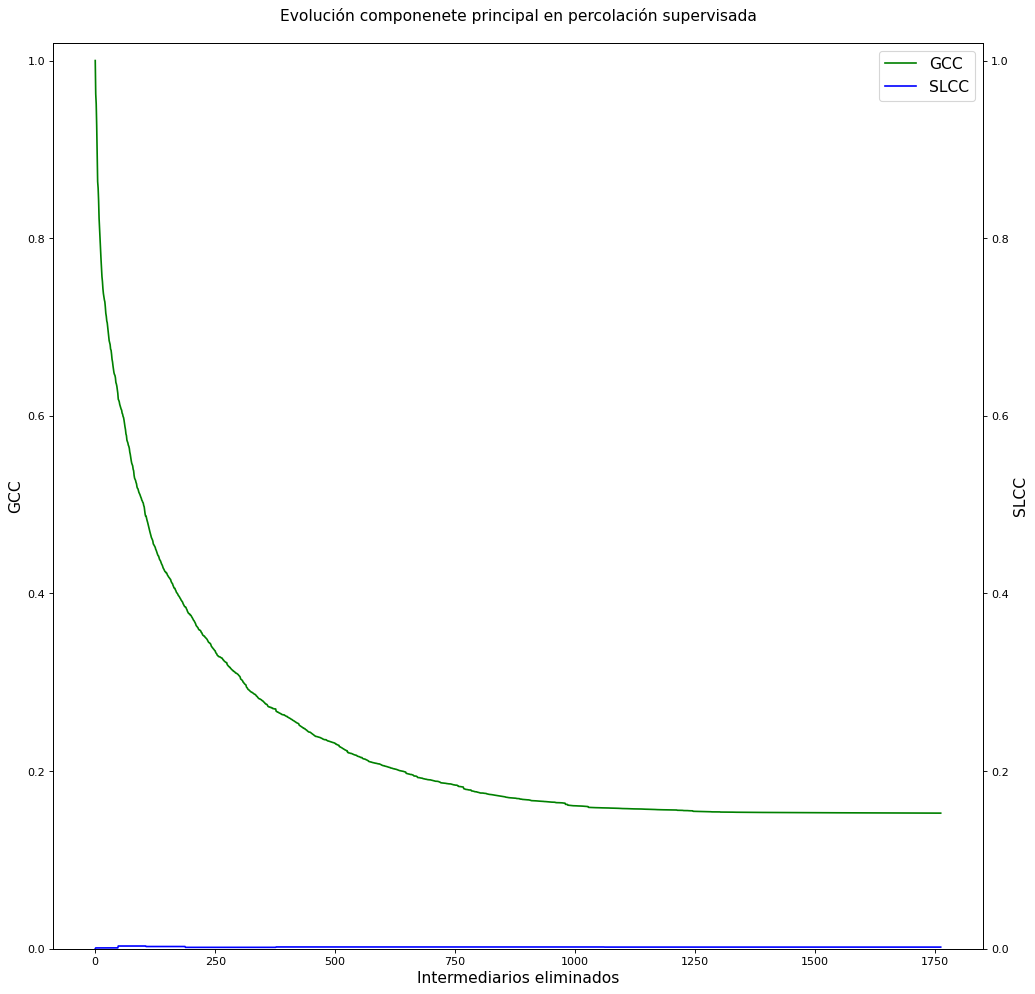

In [43]:
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación supervisada',fontsize=14,pad=20)
x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
plt.show()

In [44]:
## Random percolation for GCC
total_graph = G.number_of_nodes()
scatters_dict = {}
scatter_random_gcc = [[0,1]]
scatter_random_slcc = [[0,0]]
scatter__random_cc = [[0,1]]
current_length_gcc = total_graph
Percolation_graph = G.copy()
j=1
while current_length_gcc/total_graph > 0.05:
    random.seed(32)
    random_id = random.choice(list(dict(Percolation_graph.degree(labels['Intermediary'])).keys()))
    Percolation_graph.remove_node(random_id)
    G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    scatter__random_cc.append([j,len(G_sorted)])
    Gcc = Percolation_graph.subgraph(G_sorted[0])
    Slcc = Percolation_graph.subgraph(G_sorted[1])
    current_length_gcc = len(Gcc)
    current_length_slcc = len(Slcc)    
    print('The total number of components in Gcc is: ',current_length_gcc)
    print('The total number of components in Slcc is: ',current_length_slcc)
    print('Proportion gcc',current_length_gcc/total_graph)
    print('Proportion slcc',current_length_slcc/total_graph)    
    scatter_random_gcc.append([j,current_length_gcc/total_graph])
    scatter_random_slcc.append([j,current_length_slcc/total_graph])
    j=j+1

The total number of components in Gcc is:  310612
The total number of components in Slcc is:  8
Proportion gcc 0.9998004338953372
Proportion slcc 2.575046511777619e-05
The total number of components in Gcc is:  310583
The total number of components in Slcc is:  11
Proportion gcc 0.9997070884592852
Proportion slcc 3.540688953694226e-05
The total number of components in Gcc is:  310521
The total number of components in Slcc is:  11
Proportion gcc 0.9995075223546225
Proportion slcc 3.540688953694226e-05
The total number of components in Gcc is:  310509
The total number of components in Slcc is:  11
Proportion gcc 0.9994688966569458
Proportion slcc 3.540688953694226e-05
The total number of components in Gcc is:  309607
The total number of components in Slcc is:  149
Proportion gcc 0.9965655317149166
Proportion slcc 0.00047960241281858154
The total number of components in Gcc is:  309568
The total number of components in Slcc is:  149
Proportion gcc 0.9964399981974674
Proportion slcc 0.0004

The total number of components in Gcc is:  304149
The total number of components in Slcc is:  309
Proportion gcc 0.9789972768883138
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  304120
The total number of components in Slcc is:  309
Proportion gcc 0.9789039314522618
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  304014
The total number of components in Slcc is:  309
Proportion gcc 0.9785627377894514
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  303679
The total number of components in Slcc is:  309
Proportion gcc 0.9774844370626444
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  303391
The total number of components in Slcc is:  309
Proportion gcc 0.9765574203184045
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  303378
The total number of components in Slcc is:  309
Proportion gcc 0.9765155758125881
Proportion slcc 0.

The total number of components in Gcc is:  293139
The total number of components in Slcc is:  309
Proportion gcc 0.9435581992699743
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  292988
The total number of components in Slcc is:  309
Proportion gcc 0.9430721592408763
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  292770
The total number of components in Slcc is:  309
Proportion gcc 0.9423704590664169
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  292744
The total number of components in Slcc is:  309
Proportion gcc 0.9422867700547841
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  292692
The total number of components in Slcc is:  309
Proportion gcc 0.9421193920315186
Proportion slcc 0.0009946117151741053
The total number of components in Gcc is:  292261
The total number of components in Slcc is:  309
Proportion gcc 0.9407320857232984
Proportion slcc 0.

The total number of components in Gcc is:  280798
The total number of components in Slcc is:  2427
Proportion gcc 0.9038348880176649
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  279150
The total number of components in Slcc is:  2427
Proportion gcc 0.898530292203403
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  279149
The total number of components in Slcc is:  2427
Proportion gcc 0.8985270733952632
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  279078
The total number of components in Slcc is:  2427
Proportion gcc 0.8982985380173429
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  278882
The total number of components in Slcc is:  2427
Proportion gcc 0.8976676516219574
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  278846
The total number of components in Slcc is:  2427
Proportion gcc 0.8975517745289274
Proportion slcc 0.

The total number of components in Gcc is:  273718
The total number of components in Slcc is:  2427
Proportion gcc 0.8810457263884329
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  273286
The total number of components in Slcc is:  2427
Proportion gcc 0.879655201272073
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  273239
The total number of components in Slcc is:  2427
Proportion gcc 0.879503917289506
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  273227
The total number of components in Slcc is:  2427
Proportion gcc 0.8794652915918294
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  273122
The total number of components in Slcc is:  2427
Proportion gcc 0.8791273167371586
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  273019
The total number of components in Slcc is:  2427
Proportion gcc 0.8787957794987672
Proportion slcc 0.0

The total number of components in Gcc is:  263692
The total number of components in Slcc is:  2427
Proportion gcc 0.8487739559795798
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  261950
The total number of components in Slcc is:  2427
Proportion gcc 0.8431667922001841
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  261947
The total number of components in Slcc is:  2427
Proportion gcc 0.8431571357757649
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  261754
The total number of components in Slcc is:  2427
Proportion gcc 0.8425359058047986
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  261447
The total number of components in Slcc is:  2427
Proportion gcc 0.8415477317059039
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  261388
The total number of components in Slcc is:  2427
Proportion gcc 0.8413578220256603
Proportion slcc 0

The total number of components in Gcc is:  248910
The total number of components in Slcc is:  2427
Proportion gcc 0.8011935340582089
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  248879
The total number of components in Slcc is:  2427
Proportion gcc 0.8010937510058775
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  248531
The total number of components in Slcc is:  2427
Proportion gcc 0.7999736057732543
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  248422
The total number of components in Slcc is:  2427
Proportion gcc 0.7996227556860246
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  248413
The total number of components in Slcc is:  2427
Proportion gcc 0.7995937864127671
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  248409
The total number of components in Slcc is:  2427
Proportion gcc 0.7995809111802082
Proportion slcc 0

The total number of components in Gcc is:  240581
The total number of components in Slcc is:  2427
Proportion gcc 0.7743840810624641
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  240524
The total number of components in Slcc is:  2427
Proportion gcc 0.7742006089985001
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  240518
The total number of components in Slcc is:  2427
Proportion gcc 0.7741812961496617
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  240046
The total number of components in Slcc is:  2427
Proportion gcc 0.7726620187077129
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  239877
The total number of components in Slcc is:  2427
Proportion gcc 0.7721180401320998
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  239783
The total number of components in Slcc is:  2427
Proportion gcc 0.771815472166966
Proportion slcc 0.

The total number of components in Gcc is:  233347
The total number of components in Slcc is:  2427
Proportion gcc 0.7510992229797151
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  233156
The total number of components in Slcc is:  2427
Proportion gcc 0.7504844306250281
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  233156
The total number of components in Slcc is:  2427
Proportion gcc 0.7504844306250281
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  232870
The total number of components in Slcc is:  2427
Proportion gcc 0.7495638514970676
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  232870
The total number of components in Slcc is:  2427
Proportion gcc 0.7495638514970676
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  232717
The total number of components in Slcc is:  2427
Proportion gcc 0.7490713738516902
Proportion slcc 0

The total number of components in Gcc is:  226154
The total number of components in Slcc is:  2427
Proportion gcc 0.7279463360306946
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  226153
The total number of components in Slcc is:  2427
Proportion gcc 0.7279431172225548
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  225606
The total number of components in Slcc is:  2427
Proportion gcc 0.7261824291701269
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  225262
The total number of components in Slcc is:  2427
Proportion gcc 0.7250751591700625
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  225244
The total number of components in Slcc is:  2427
Proportion gcc 0.7250172206235476
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  225243
The total number of components in Slcc is:  2427
Proportion gcc 0.7250140018154078
Proportion slcc 0

The total number of components in Gcc is:  218594
The total number of components in Slcc is:  2427
Proportion gcc 0.7036121464943961
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  216933
The total number of components in Slcc is:  2427
Proportion gcc 0.6982657061743178
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  216790
The total number of components in Slcc is:  2427
Proportion gcc 0.6978054166103376
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  216717
The total number of components in Slcc is:  2427
Proportion gcc 0.6975704436161378
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  216711
The total number of components in Slcc is:  2427
Proportion gcc 0.6975511307672995
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  216710
The total number of components in Slcc is:  2427
Proportion gcc 0.6975479119591598
Proportion slcc 0

The total number of components in Gcc is:  208097
The total number of components in Slcc is:  2427
Proportion gcc 0.669824317451734
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  208091
The total number of components in Slcc is:  2427
Proportion gcc 0.6698050046028956
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  208069
The total number of components in Slcc is:  2427
Proportion gcc 0.6697341908238218
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  208068
The total number of components in Slcc is:  2427
Proportion gcc 0.669730972015682
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  208068
The total number of components in Slcc is:  2427
Proportion gcc 0.669730972015682
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  205579
The total number of components in Slcc is:  2427
Proportion gcc 0.6617193585559139
Proportion slcc 0.00

The total number of components in Gcc is:  198835
The total number of components in Slcc is:  2427
Proportion gcc 0.6400117164616286
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  198809
The total number of components in Slcc is:  2427
Proportion gcc 0.6399280274499958
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  198800
The total number of components in Slcc is:  2427
Proportion gcc 0.6398990581767383
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  198783
The total number of components in Slcc is:  2427
Proportion gcc 0.6398443384383631
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  198765
The total number of components in Slcc is:  2427
Proportion gcc 0.639786399891848
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  198727
The total number of components in Slcc is:  2427
Proportion gcc 0.6396640851825386
Proportion slcc 0.

The total number of components in Gcc is:  194714
The total number of components in Slcc is:  2427
Proportion gcc 0.6267470081178341
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  194630
The total number of components in Slcc is:  2427
Proportion gcc 0.6264766282340974
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  194607
The total number of components in Slcc is:  2427
Proportion gcc 0.6264025956468838
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  194589
The total number of components in Slcc is:  2427
Proportion gcc 0.6263446571003689
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  194549
The total number of components in Slcc is:  2427
Proportion gcc 0.62621590477478
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  194549
The total number of components in Slcc is:  2427
Proportion gcc 0.62621590477478
Proportion slcc 0.007

The total number of components in Gcc is:  190325
The total number of components in Slcc is:  2427
Proportion gcc 0.6126196591925942
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  190299
The total number of components in Slcc is:  2427
Proportion gcc 0.6125359701809614
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  190293
The total number of components in Slcc is:  2427
Proportion gcc 0.612516657332123
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  189852
The total number of components in Slcc is:  2427
Proportion gcc 0.6110971629425056
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  189796
The total number of components in Slcc is:  2427
Proportion gcc 0.6109169096866812
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  189792
The total number of components in Slcc is:  2427
Proportion gcc 0.6109040344541223
Proportion slcc 0.

The total number of components in Gcc is:  186651
The total number of components in Slcc is:  2427
Proportion gcc 0.6007937580872554
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  186521
The total number of components in Slcc is:  2427
Proportion gcc 0.6003753130290916
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  186491
The total number of components in Slcc is:  2427
Proportion gcc 0.6002787487849
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  186473
The total number of components in Slcc is:  2427
Proportion gcc 0.6002208102383849
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  186276
The total number of components in Slcc is:  2427
Proportion gcc 0.5995867050348597
Proportion slcc 0.007812047355105351
The total number of components in Gcc is:  185748
The total number of components in Slcc is:  2427
Proportion gcc 0.5978871743370865
Proportion slcc 0.00

The total number of components in Gcc is:  166872
The total number of components in Slcc is:  503
Proportion gcc 0.5371289518916935
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  166447
The total number of components in Slcc is:  503
Proportion gcc 0.5357609584323116
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  166443
The total number of components in Slcc is:  503
Proportion gcc 0.5357480831997528
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  165996
The total number of components in Slcc is:  503
Proportion gcc 0.5343092759612971
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  159737
The total number of components in Slcc is:  503
Proportion gcc 0.5141627558147769
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  159655
The total number of components in Slcc is:  503
Proportion gcc 0.5138988135473197
Proportion slcc 0.

The total number of components in Gcc is:  150201
The total number of components in Slcc is:  503
Proportion gcc 0.4834682013943877
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  150201
The total number of components in Slcc is:  503
Proportion gcc 0.4834682013943877
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  150068
The total number of components in Slcc is:  503
Proportion gcc 0.48304009991180463
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  150023
The total number of components in Slcc is:  503
Proportion gcc 0.48289525354551716
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  149985
The total number of components in Slcc is:  503
Proportion gcc 0.48277293883620775
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  149945
The total number of components in Slcc is:  503
Proportion gcc 0.48264418651061886
Proportion slc

The total number of components in Gcc is:  145154
The total number of components in Slcc is:  503
Proportion gcc 0.4672228767132106
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  145115
The total number of components in Slcc is:  503
Proportion gcc 0.46709734319576146
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  145070
The total number of components in Slcc is:  503
Proportion gcc 0.466952496829474
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  145070
The total number of components in Slcc is:  503
Proportion gcc 0.466952496829474
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  144972
The total number of components in Slcc is:  503
Proportion gcc 0.4666370536317812
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  144962
The total number of components in Slcc is:  503
Proportion gcc 0.466604865550384
Proportion slcc 0.00

The total number of components in Gcc is:  141705
The total number of components in Slcc is:  535
Proportion gcc 0.4561212074393094
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  141593
The total number of components in Slcc is:  535
Proportion gcc 0.4557607009276605
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  141593
The total number of components in Slcc is:  535
Proportion gcc 0.4557607009276605
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  141500
The total number of components in Slcc is:  535
Proportion gcc 0.4554613517706664
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  141500
The total number of components in Slcc is:  535
Proportion gcc 0.4554613517706664
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  141499
The total number of components in Slcc is:  535
Proportion gcc 0.45545813296252663
Proportion slcc 0

The total number of components in Gcc is:  140459
The total number of components in Slcc is:  535
Proportion gcc 0.45211057249721576
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  140350
The total number of components in Slcc is:  535
Proportion gcc 0.451759722409986
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  140342
The total number of components in Slcc is:  535
Proportion gcc 0.45173397194486825
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  140310
The total number of components in Slcc is:  535
Proportion gcc 0.4516309700843972
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  140067
The total number of components in Slcc is:  535
Proportion gcc 0.4508487997064447
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  139823
The total number of components in Slcc is:  535
Proportion gcc 0.45006341052035254
Proportion slcc 

The total number of components in Gcc is:  138268
The total number of components in Slcc is:  535
Proportion gcc 0.4450581638630848
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  138264
The total number of components in Slcc is:  535
Proportion gcc 0.4450452886305259
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  138264
The total number of components in Slcc is:  535
Proportion gcc 0.4450452886305259
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  138264
The total number of components in Slcc is:  535
Proportion gcc 0.4450452886305259
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  138228
The total number of components in Slcc is:  535
Proportion gcc 0.4449294115374959
Proportion slcc 0.0017220623547512827
The total number of components in Gcc is:  138228
The total number of components in Slcc is:  535
Proportion gcc 0.4449294115374959
Proportion slcc 0.

The total number of components in Gcc is:  136950
The total number of components in Slcc is:  503
Proportion gcc 0.44081577473493117
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  136949
The total number of components in Slcc is:  503
Proportion gcc 0.4408125559267914
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  136948
The total number of components in Slcc is:  503
Proportion gcc 0.4408093371186517
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  136948
The total number of components in Slcc is:  503
Proportion gcc 0.4408093371186517
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  136945
The total number of components in Slcc is:  503
Proportion gcc 0.44079968069423253
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  136943
The total number of components in Slcc is:  503
Proportion gcc 0.4407932430779531
Proportion slcc 

The total number of components in Gcc is:  135280
The total number of components in Slcc is:  503
Proportion gcc 0.43544036514159534
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  135279
The total number of components in Slcc is:  503
Proportion gcc 0.43543714633345565
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  135239
The total number of components in Slcc is:  503
Proportion gcc 0.43530839400786675
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  135239
The total number of components in Slcc is:  503
Proportion gcc 0.43530839400786675
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  135238
The total number of components in Slcc is:  503
Proportion gcc 0.43530517519972706
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  135230
The total number of components in Slcc is:  503
Proportion gcc 0.4352794247346093
Proportion sl

The total number of components in Gcc is:  134449
The total number of components in Slcc is:  503
Proportion gcc 0.43276553557748637
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  134433
The total number of components in Slcc is:  503
Proportion gcc 0.43271403464725083
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  134422
The total number of components in Slcc is:  503
Proportion gcc 0.4326786277577139
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  134406
The total number of components in Slcc is:  503
Proportion gcc 0.43262712682747834
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  134406
The total number of components in Slcc is:  503
Proportion gcc 0.43262712682747834
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  134405
The total number of components in Slcc is:  503
Proportion gcc 0.4326239080193386
Proportion slc

The total number of components in Gcc is:  133889
The total number of components in Slcc is:  503
Proportion gcc 0.430963003019242
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  133096
The total number of components in Slcc is:  635
Proportion gcc 0.4284104881644425
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  133085
The total number of components in Slcc is:  635
Proportion gcc 0.42837508127490553
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  133081
The total number of components in Slcc is:  635
Proportion gcc 0.42836220604234665
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  132993
The total number of components in Slcc is:  635
Proportion gcc 0.4280789509260511
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  132993
The total number of components in Slcc is:  635
Proportion gcc 0.4280789509260511
Proportion slcc 0.002

The total number of components in Gcc is:  116999
The total number of components in Slcc is:  635
Proportion gcc 0.37659733353933705
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  116921
The total number of components in Slcc is:  635
Proportion gcc 0.37634626650443875
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  116159
The total number of components in Slcc is:  635
Proportion gcc 0.37389353470197056
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  116159
The total number of components in Slcc is:  635
Proportion gcc 0.37389353470197056
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  112970
The total number of components in Slcc is:  635
Proportion gcc 0.363628755544397
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  112938
The total number of components in Slcc is:  635
Proportion gcc 0.3635257536839259
Proportion slcc 0.00

The total number of components in Gcc is:  91158
The total number of components in Slcc is:  635
Proportion gcc 0.29342011240078025
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  91145
The total number of components in Slcc is:  635
Proportion gcc 0.29337826789496385
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  91145
The total number of components in Slcc is:  635
Proportion gcc 0.29337826789496385
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  91131
The total number of components in Slcc is:  635
Proportion gcc 0.29333320458100776
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  91131
The total number of components in Slcc is:  635
Proportion gcc 0.29333320458100776
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  91131
The total number of components in Slcc is:  635
Proportion gcc 0.29333320458100776
Proportion slcc 0.00204

The total number of components in Gcc is:  90978
The total number of components in Slcc is:  635
Proportion gcc 0.2928407269356303
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90869
The total number of components in Slcc is:  635
Proportion gcc 0.29248987684840055
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90868
The total number of components in Slcc is:  635
Proportion gcc 0.29248665804026086
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90867
The total number of components in Slcc is:  635
Proportion gcc 0.2924834392321211
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90854
The total number of components in Slcc is:  635
Proportion gcc 0.29244159472630477
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90853
The total number of components in Slcc is:  635
Proportion gcc 0.292438375918165
Proportion slcc 0.002043943

The total number of components in Gcc is:  90479
The total number of components in Slcc is:  635
Proportion gcc 0.291234541673909
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90479
The total number of components in Slcc is:  635
Proportion gcc 0.291234541673909
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90468
The total number of components in Slcc is:  635
Proportion gcc 0.29119913478437204
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90467
The total number of components in Slcc is:  635
Proportion gcc 0.29119591597623234
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90467
The total number of components in Slcc is:  635
Proportion gcc 0.29119591597623234
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  90466
The total number of components in Slcc is:  635
Proportion gcc 0.2911926971680926
Proportion slcc 0.0020439431

The total number of components in Gcc is:  90244
The total number of components in Slcc is:  590
Proportion gcc 0.2904781217610743
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  90243
The total number of components in Slcc is:  590
Proportion gcc 0.2904749029529346
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  90243
The total number of components in Slcc is:  590
Proportion gcc 0.2904749029529346
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  90241
The total number of components in Slcc is:  590
Proportion gcc 0.29046846533665516
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  90238
The total number of components in Slcc is:  590
Proportion gcc 0.29045880891223597
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  90238
The total number of components in Slcc is:  590
Proportion gcc 0.29045880891223597
Proportion slcc 0.00189909

The total number of components in Gcc is:  83585
The total number of components in Slcc is:  590
Proportion gcc 0.26904407835866534
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  83074
The total number of components in Slcc is:  590
Proportion gcc 0.2673992673992674
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  83058
The total number of components in Slcc is:  590
Proportion gcc 0.26734776646903186
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  83005
The total number of components in Slcc is:  590
Proportion gcc 0.26717716963762655
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  82903
The total number of components in Slcc is:  590
Proportion gcc 0.26684885120737495
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  82332
The total number of components in Slcc is:  590
Proportion gcc 0.2650109117595937
Proportion slcc 0.0018990

The total number of components in Gcc is:  81767
The total number of components in Slcc is:  584
Proportion gcc 0.26319228516065074
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81767
The total number of components in Slcc is:  584
Proportion gcc 0.26319228516065074
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81765
The total number of components in Slcc is:  584
Proportion gcc 0.26318584754437124
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81765
The total number of components in Slcc is:  584
Proportion gcc 0.26318584754437124
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81762
The total number of components in Slcc is:  584
Proportion gcc 0.2631761911199521
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81761
The total number of components in Slcc is:  584
Proportion gcc 0.26317297231181236
Proportion slcc 0.0

The total number of components in Gcc is:  81539
The total number of components in Slcc is:  584
Proportion gcc 0.2624583969047941
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81539
The total number of components in Slcc is:  584
Proportion gcc 0.2624583969047941
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81523
The total number of components in Slcc is:  584
Proportion gcc 0.2624068959745585
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81516
The total number of components in Slcc is:  584
Proportion gcc 0.2623843643175805
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81516
The total number of components in Slcc is:  584
Proportion gcc 0.2623843643175805
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  81516
The total number of components in Slcc is:  584
Proportion gcc 0.2623843643175805
Proportion slcc 0.001879

The total number of components in Gcc is:  70170
The total number of components in Slcc is:  584
Proportion gcc 0.2258637671642944
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  70170
The total number of components in Slcc is:  584
Proportion gcc 0.2258637671642944
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  70169
The total number of components in Slcc is:  584
Proportion gcc 0.22586054835615468
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  70169
The total number of components in Slcc is:  584
Proportion gcc 0.22586054835615468
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  70160
The total number of components in Slcc is:  584
Proportion gcc 0.2258315790828972
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  70160
The total number of components in Slcc is:  584
Proportion gcc 0.2258315790828972
Proportion slcc 0.0018

The total number of components in Gcc is:  59367
The total number of components in Slcc is:  584
Proportion gcc 0.1910909828308774
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  59367
The total number of components in Slcc is:  584
Proportion gcc 0.1910909828308774
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  59366
The total number of components in Slcc is:  584
Proportion gcc 0.19108776402273767
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  59366
The total number of components in Slcc is:  584
Proportion gcc 0.19108776402273767
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  59366
The total number of components in Slcc is:  584
Proportion gcc 0.19108776402273767
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  59366
The total number of components in Slcc is:  584
Proportion gcc 0.19108776402273767
Proportion slcc 0.00

IndexError: Cannot choose from an empty sequence

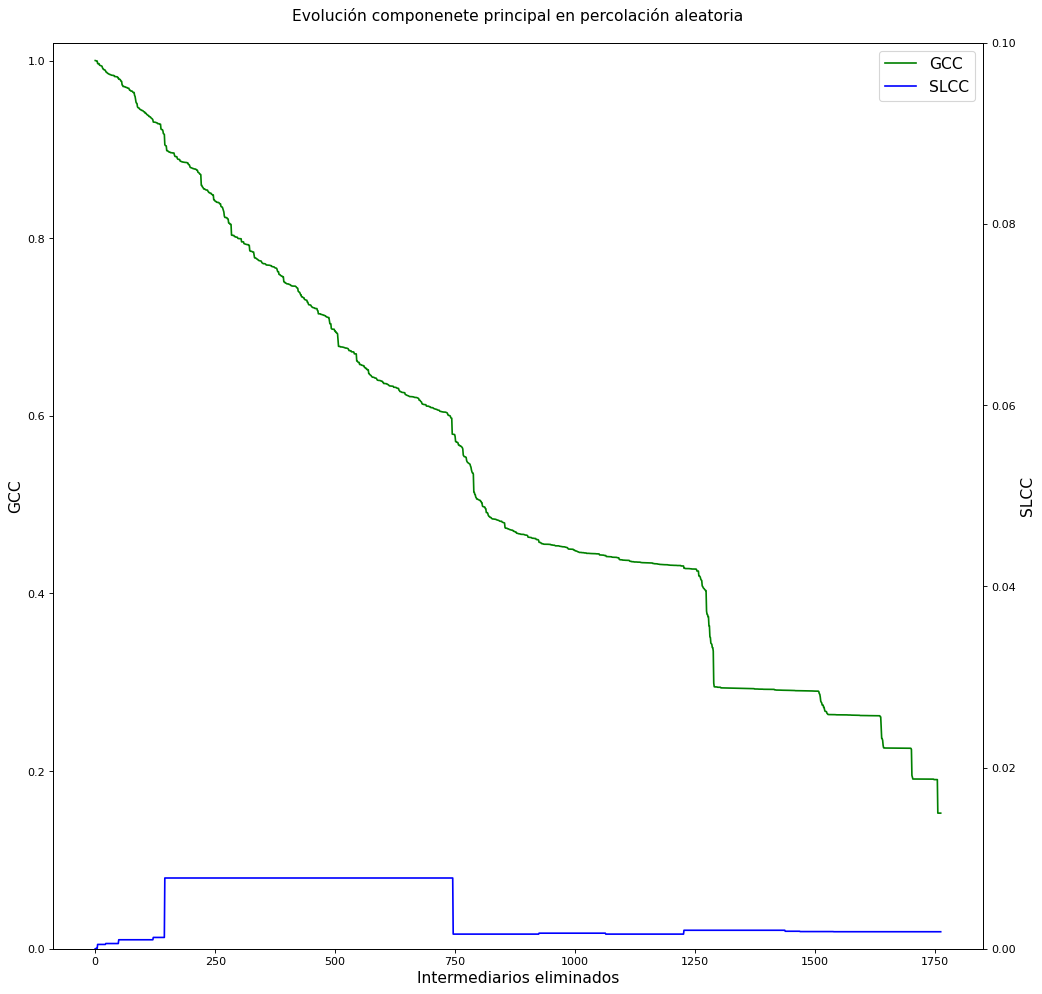

In [48]:
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación aleatoria',fontsize=14,pad=20)
x_val_gcc = [x[0] for x in scatter_random_gcc]
y_val_gcc = [x[1] for x in scatter_random_gcc]
x_val_sgcc = [x[0] for x in scatter_random_slcc]
y_val_sgcc = [x[1] for x in scatter_random_slcc]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)

plt.show()

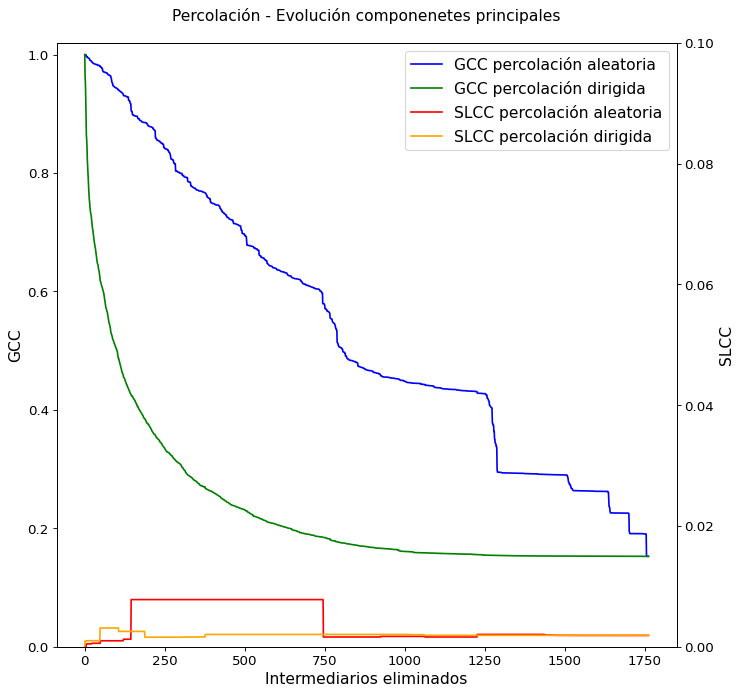

In [76]:
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación - Evolución componenetes principales',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

x_val_gcc_random = [x[0] for x in scatter_random_gcc]
y_val_gcc_random = [x[1] for x in scatter_random_gcc]
x_val_sgcc_random = [x[0] for x in scatter_random_slcc]
y_val_sgcc_random = [x[1] for x in scatter_random_slcc]

ax2 = ax1.twinx()
lns0 = ax1.plot(x_val_gcc_random, y_val_gcc_random, color='blue',label="GCC percolación aleatoria")
lns1 = ax1.plot(x_val_gcc, y_val_gcc, color='green',label="GCC percolación dirigida")
lns2 = ax2.plot(x_val_sgcc_random, y_val_sgcc_random, color='red',label="SLCC percolación aleatoria")
lns3 =ax2.plot(x_val_gcc, y_val_sgcc, color='orange',label="SLCC percolación dirigida")
lns = lns0+lns1+lns2+lns3
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
ax1.tick_params(axis="x", labelsize=12) 
ax1.tick_params(axis="y", labelsize=12)
plt.yticks(fontsize=12)
plt.show()

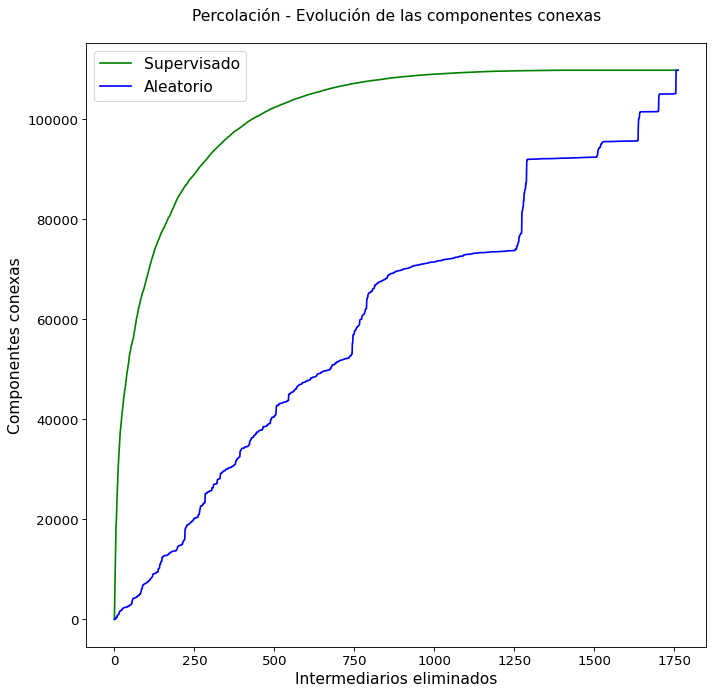

In [78]:
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación - Evolución de las componentes conexas',fontsize=14,pad=20)
x_val_cc = [x[0] for x in scatter_cc]
y_val_cc = [x[1] for x in scatter_cc]
x_val_cc_random = [x[0] for x in scatter__random_cc]
y_val_cc_random = [x[1] for x in scatter__random_cc]

ax1.plot(x_val_cc, y_val_cc, 'g-',label="Supervisado")
ax1.plot(x_val_cc_random, y_val_cc_random, 'b-',label="Aleatorio")
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylabel('Componentes conexas',fontsize=14)
ax1.legend(loc="upper left",fontsize=14)
#ax1.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
G.number_of_nodes()

In [ ]:
A = nx.adjacency_matrix(G)

In [ ]:
def get_stats(stats):
    array = list(stats.values())
    response = {
        "min": min(array),
        "max": max(array),
        "mean": np.mean(array),
        "std": np.std(array)
    }
    return response

In [43]:
print("degree_centrality")
degree_centrality = nx.degree_centrality(G)
print("stats_information_centrality")
#stats_information_centrality = nx.information_centrality(G)
print("stats_closeness_centrality")
stats_closeness_centrality = nx.closeness_centrality(G)
print("stats_betweenness_centrality")
stats_betweenness_centrality = nx.betweenness_centrality(G)
print("stats_current_flow_closeness_centrality")
#stats_current_flow_closeness_centrality = nx.current_flow_closeness_centrality(G)

degree_centrality
stats_information_centrality
stats_closeness_centrality


KeyboardInterrupt: 

In [51]:
## Degree centrality
degree_centrality = nx.degree_centrality(G)
stats_degree_centrality = get_stats(nx.degree_centrality(G))
print(stats_degree_centrality)

{'min': 3.218818500481213e-06, 'max': 0.02258323059937619, 'mean': 7.447790300433631e-06, 'std': 8.430010369957995e-05}


In [52]:
## Information centrality
stats_information_centrality = get_stats(nx.information_centrality(G))
print(stats_information_centrality)

KeyboardInterrupt: 

In [ ]:
## Closeness centrality
stats_closeness_centrality = get_stats(nx.closeness_centrality(G))
print(stats_closeness_centrality)

In [ ]:
## Betwenness centrality
stats_betweenness_centrality = get_stats(nx.betweenness_centrality(G, k=100))
print(stats_betweenness_centrality)

In [ ]:
stats_current_flow_closeness_centrality = get_stats(nx.current_flow_closeness_centrality(G))